In [201]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# API / Web Scraping

In [202]:
api_url = 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37'
valid = requests.get(api_url)

if valid.status_code == 200:
    data = valid.json()
    print('Valid API')
else:
    print(f"Error: {valid.status_code}")

Valid API


In [203]:
api_key = 'aquafox27'
api_url = 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37'  # Replace with the actual API endpoint
headers = {'api_key': api_key}  
response = requests.get(api_url, headers=headers)
if response.status_code == 200:
    data = response.json()
else:
    print(f'Error: {response.status_code}')
    print(response.text)

In [204]:
response

<Response [200]>

In [205]:
data

{'Header': [{'status': 'Success',
   'request_time': '2024-04-07T18:31:53-04:00',
   'url': 'https://aqs.epa.gov/data/api/annualData/byState?email=test@aqs.api&key=test&param=45201&bdate=19950515&edate=19950515&state=37',
   'rows': 27}],
 'Data': [{'state_code': '37',
   'county_code': '021',
   'site_number': '0032',
   'parameter_code': '45201',
   'poc': 1,
   'latitude': 35.558333,
   'longitude': -82.520833,
   'datum': 'WGS84',
   'parameter': 'Benzene',
   'sample_duration_code': '3',
   'sample_duration': '4 HOUR',
   'pollutant_standard': None,
   'metric_used': 'Observed Values',
   'method': '6L PRESSURIZED CANISTER - DUAL FID - PAMS',
   'year': 1995,
   'units_of_measure': 'Parts per billion Carbon',
   'event_type': 'No Events',
   'observation_count': 10,
   'observation_percent': 3.0,
   'validity_indicator': 'N',
   'valid_day_count': 0,
   'required_day_count': 54,
   'exceptional_data_count': 0,
   'null_observation_count': 0,
   'primary_exceedance_count': None,
  

In [206]:
df = pd.DataFrame(data['Data'])
df.head()

state_code county_code site_number parameter_code  poc   latitude  \
0         37         021        0032          45201    1  35.558333   
1         37         077        0001          45201    1  36.141111   
2         37         119        0034          45201    1  35.248754   
3         37         119        0034          45201    2  35.248754   
4         37         159        0022          45201    1  35.534482   

   longitude  datum parameter sample_duration_code  ... fiftieth_percentile  \
0 -82.520833  WGS84   Benzene                    3  ...                 7.7   
1 -78.768056  WGS84   Benzene                    B  ...                 2.0   
2 -80.766181  WGS84   Benzene                    B  ...                 6.0   
3 -80.766181  WGS84   Benzene                    3  ...                 6.4   
4 -80.667560  WGS84   Benzene                    3  ...                 2.7   

  tenth_percentile    local_site_name                 site_address  \
0              1.8               None  LONDON RD ASHVILLE NC 28803   
1              1.3             Butner           800 Central Avenue   
2              2.1               None      PLAZA ROAD AND LAKEDELL   
3              1.7               None      PLAZA ROAD AND LAKEDELL   
4              1.0  Enochville School         925 N ENOCHVILLE AVE   

            state       county         city  cbsa_code  \
0  North Carolina     Buncombe    Asheville      11700   
1  North Carolina    Granville       Butner      37080   
2  North Carolina  Mecklenburg    Charlotte      16740   
3  North Carolina  Mecklenburg    Charlotte      16740   
4  North Carolina        Rowan  China Grove      16740   

                                cbsa date_of_last_change  
0                      Asheville, NC          2020-05-21  
1                         Oxford, NC          2020-05-21  
2  Charlotte-Concord-Gastonia, NC-SC          2020-05-21  
3  Charlotte-Concord-Gastonia, NC-SC          2020-05-21  
4  Charlotte-Concord-Gastonia, NC-SC          2020-05-21  

[5 rows x 56 columns]

In [207]:
df.to_excel('WEATHER.xlsx', index=False, encoding="UTF-8")

C:\Users\choks\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning:

the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'



# Data Cleaning

In [208]:
columns_to_drop = ["pollutant_standard", "valid_day_count", "validity_indicator", "exceptional_data_count", "null_observation_count", "primary_exceedance_count", "secondary_exceedance_count", "certification_indicator", "first_max_nonoverlap_value", "first_max_n_o_datetime", "second_max_nonoverlap_value", "second_max_n_o_datetime", "local_site_name"]
df = df.drop(columns=columns_to_drop, axis=1)

In [209]:
df.head()

state_code county_code site_number parameter_code  poc   latitude  \
0         37         021        0032          45201    1  35.558333   
1         37         077        0001          45201    1  36.141111   
2         37         119        0034          45201    1  35.248754   
3         37         119        0034          45201    2  35.248754   
4         37         159        0022          45201    1  35.534482   

   longitude  datum parameter sample_duration_code  ...  \
0 -82.520833  WGS84   Benzene                    3  ...   
1 -78.768056  WGS84   Benzene                    B  ...   
2 -80.766181  WGS84   Benzene                    B  ...   
3 -80.766181  WGS84   Benzene                    3  ...   
4 -80.667560  WGS84   Benzene                    3  ...   

  seventy_fifth_percentile fiftieth_percentile tenth_percentile  \
0                      8.0                 7.7              1.8   
1                      2.9                 2.0              1.3   
2                      7.9                 6.0              2.1   
3                     14.6                 6.4              1.7   
4                      3.6                 2.7              1.0   

                  site_address           state       county         city  \
0  LONDON RD ASHVILLE NC 28803  North Carolina     Buncombe    Asheville   
1           800 Central Avenue  North Carolina    Granville       Butner   
2      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
3      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
4         925 N ENOCHVILLE AVE  North Carolina        Rowan  China Grove   

   cbsa_code                               cbsa  date_of_last_change  
0      11700                      Asheville, NC           2020-05-21  
1      37080                         Oxford, NC           2020-05-21  
2      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
3      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
4      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  

[5 rows x 43 columns]

In [210]:
df.isnull().any()

state_code                  False
county_code                 False
site_number                 False
parameter_code              False
poc                         False
latitude                    False
longitude                   False
datum                       False
parameter                   False
sample_duration_code        False
sample_duration             False
metric_used                 False
method                      False
year                        False
units_of_measure            False
event_type                  False
observation_count           False
observation_percent         False
required_day_count          False
arithmetic_mean             False
standard_deviation          False
first_max_value             False
first_max_datetime          False
second_max_value            False
second_max_datetime         False
third_max_value             False
third_max_datetime          False
fourth_max_value            False
fourth_max_datetime         False
ninety_ninth_p

In [211]:
df.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
metric_used                 0
method                      0
year                        0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
required_day_count          0
arithmetic_mean             0
standard_deviation          0
first_max_value             0
first_max_datetime          0
second_max_value            0
second_max_datetime         0
third_max_value             0
third_max_datetime          0
fourth_max_value            0
fourth_max_datetime         0
ninety_ninth_percentile     0
ninety_eighth_percentile    0
ninety_fifth_percentile     0
ninetieth_percentile        0
seventy_fi

In [212]:
dfc = df.dropna()

In [213]:
dfc.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
metric_used                 0
method                      0
year                        0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
required_day_count          0
arithmetic_mean             0
standard_deviation          0
first_max_value             0
first_max_datetime          0
second_max_value            0
second_max_datetime         0
third_max_value             0
third_max_datetime          0
fourth_max_value            0
fourth_max_datetime         0
ninety_ninth_percentile     0
ninety_eighth_percentile    0
ninety_fifth_percentile     0
ninetieth_percentile        0
seventy_fi

In [214]:
dfc.head()  #cleaned dataset

state_code county_code site_number parameter_code  poc   latitude  \
0         37         021        0032          45201    1  35.558333   
1         37         077        0001          45201    1  36.141111   
2         37         119        0034          45201    1  35.248754   
3         37         119        0034          45201    2  35.248754   
4         37         159        0022          45201    1  35.534482   

   longitude  datum parameter sample_duration_code  ...  \
0 -82.520833  WGS84   Benzene                    3  ...   
1 -78.768056  WGS84   Benzene                    B  ...   
2 -80.766181  WGS84   Benzene                    B  ...   
3 -80.766181  WGS84   Benzene                    3  ...   
4 -80.667560  WGS84   Benzene                    3  ...   

  seventy_fifth_percentile fiftieth_percentile tenth_percentile  \
0                      8.0                 7.7              1.8   
1                      2.9                 2.0              1.3   
2                      7.9                 6.0              2.1   
3                     14.6                 6.4              1.7   
4                      3.6                 2.7              1.0   

                  site_address           state       county         city  \
0  LONDON RD ASHVILLE NC 28803  North Carolina     Buncombe    Asheville   
1           800 Central Avenue  North Carolina    Granville       Butner   
2      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
3      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
4         925 N ENOCHVILLE AVE  North Carolina        Rowan  China Grove   

   cbsa_code                               cbsa  date_of_last_change  
0      11700                      Asheville, NC           2020-05-21  
1      37080                         Oxford, NC           2020-05-21  
2      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
3      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
4      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  

[5 rows x 43 columns]

In [215]:
dfc.to_excel('WEATHERMAIN.xlsx', index=False, encoding="UTF-8")

C:\Users\choks\anaconda3\Lib\site-packages\pandas\util\_decorators.py:211: FutureWarning:

the 'encoding' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'encoding'



# Exploratory Data Analysis / Data Visualization

In [216]:
dfc.describe()

poc   latitude  longitude    year  observation_count  \
count  21.000000  21.000000  21.000000    21.0           21.00000   
mean    1.190476  35.748069 -79.446518  1995.0           23.00000   
std     0.402374   0.314859   1.306930     0.0           10.81203   
min     1.000000  35.029403 -82.520833  1995.0            6.00000   
25%     1.000000  35.558333 -80.667560  1995.0           12.00000   
50%     1.000000  35.774875 -78.904167  1995.0           22.00000   
75%     1.000000  36.035556 -78.635190  1995.0           33.00000   
max     2.000000  36.141111 -77.368298  1995.0           41.00000   

       observation_percent  required_day_count  arithmetic_mean  \
count            21.000000           21.000000        21.000000   
mean              2.142857          210.666667         5.226633   
std               1.276155          128.274445         2.874095   
min               1.000000           27.000000         0.000000   
25%               1.000000           88.000000         2.960870   
50%               2.000000          213.000000         4.386486   
75%               3.000000          365.000000         7.570833   
max               5.000000          365.000000        10.287879   

       standard_deviation  first_max_value  second_max_value  third_max_value  \
count           21.000000        21.000000         21.000000        21.000000   
mean             3.311908        13.642857         10.733333         9.080952   
std              1.757624         6.254244          5.437401         5.320490   
min              0.000000         0.000000          0.000000         0.000000   
25%              2.106322         8.000000          6.000000         4.600000   
50%              3.546191        14.800000         10.600000         8.800000   
75%              4.075894        17.800000         14.600000        12.700000   
max              7.459207        25.800000         20.400000        20.000000   

       fourth_max_value  ninety_ninth_percentile  ninety_eighth_percentile  \
count         21.000000                21.000000                 21.000000   
mean           8.038095                13.642857                 13.642857   
std            4.829024                 6.254244                  6.254244   
min            0.000000                 0.000000                  0.000000   
25%            4.000000                 8.000000                  8.000000   
50%            7.600000                14.800000                 14.800000   
75%           11.600000                17.800000                 17.800000   
max           16.800000                25.800000                 25.800000   

       ninety_fifth_percentile  ninetieth_percentile  \
count                21.000000             21.000000   
mean                 12.161905              9.652381   
std                   5.881962              5.729277   
min                   0.000000              0.000000   
25%                   7.900000              4.700000   
50%                  13.400000              9.100000   
75%                  15.700000             14.600000   
max                  25.800000             20.000000   

       seventy_fifth_percentile  fiftieth_percentile  tenth_percentile  
count                 21.000000            21.000000         21.000000  
mean                   7.285714             4.757143          1.995238  
std                    4.702689             2.798852          1.656042  
min                    0.000000             0.000000          0.000000  
25%                    3.600000             2.600000          1.200000  
50%                    5.500000             4.200000          1.700000  
75%                   11.500000             6.600000          2.100000  
max                   15.600000            10.800000          6.100000

In [217]:
benzenestats = dfc['arithmetic_mean'].describe()
print(benzenestats)


count    21.000000
mean      5.226633
std       2.874095
min       0.000000
25%       2.960870
50%       4.386486
75%       7.570833
max      10.287879
Name: arithmetic_mean, dtype: float64


C:\Users\choks\AppData\Local\Temp\ipykernel_25068\1282773394.py:3: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



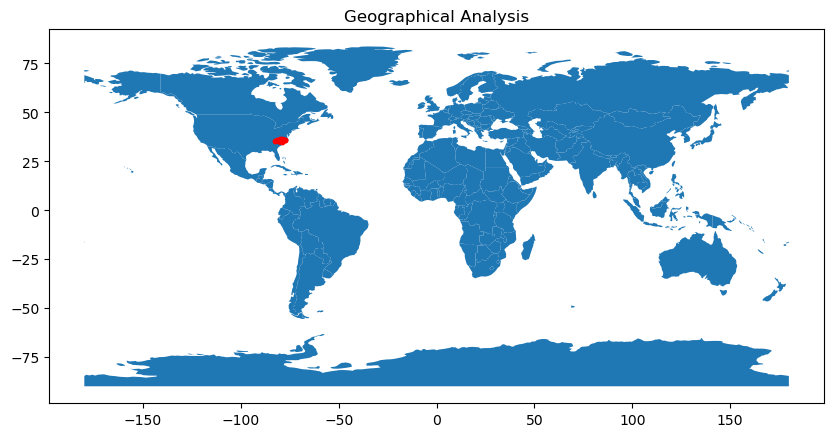

In [218]:
geom = [Point(xy) for xy in zip(dfc['longitude'], dfc['latitude'])]
gdfc = gpd.GeoDataFrame(dfc, geometry=geom)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6))
gdfc.plot(ax=ax, color='red', marker='o', markersize=10)
plt.title('Geographical Analysis')
plt.show()


The whole dataset is based on a country code 37, which corresponds to North Carolina, the above plot shows the region where the data is taken from, for the air quality measurements of the benzene levels.

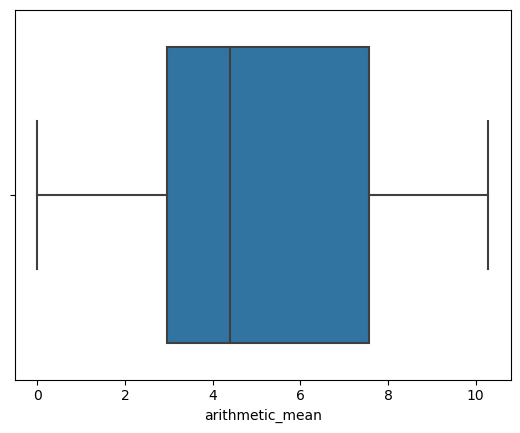

In [219]:
sns.boxplot(x=dfc['arithmetic_mean'])
plt.show()


The above plot is used to show the outlier detection and it can be seen that there are not any outliers in the dataset.

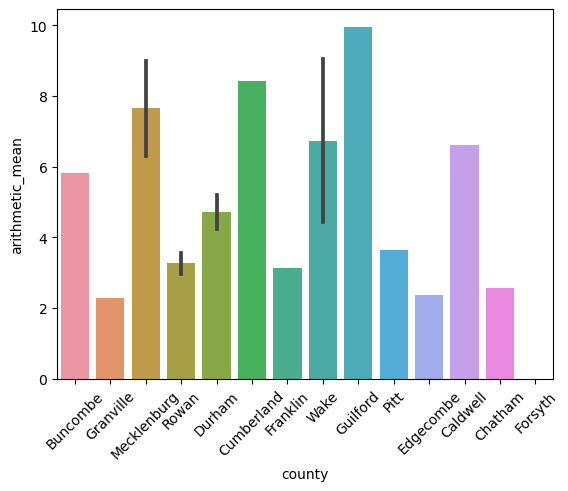

In [220]:
sns.barplot(x='county', y='arithmetic_mean', data=dfc)
plt.xticks(rotation=45)
plt.show()

The arithmetic mean here is a parameter (air quality measurement) for different counties in the state of North Carolina. 

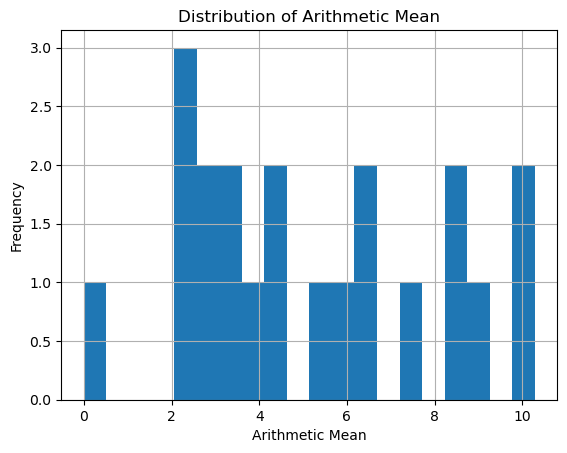

In [221]:
dfc['arithmetic_mean'].hist(bins=20)
plt.title('Distribution of Arithmetic Mean')
plt.xlabel('Arithmetic Mean')
plt.ylabel('Frequency')
plt.show()

The above plot shows the percentage of to what level the benzene levels fall in the air quality measurements in the state of North carolina.

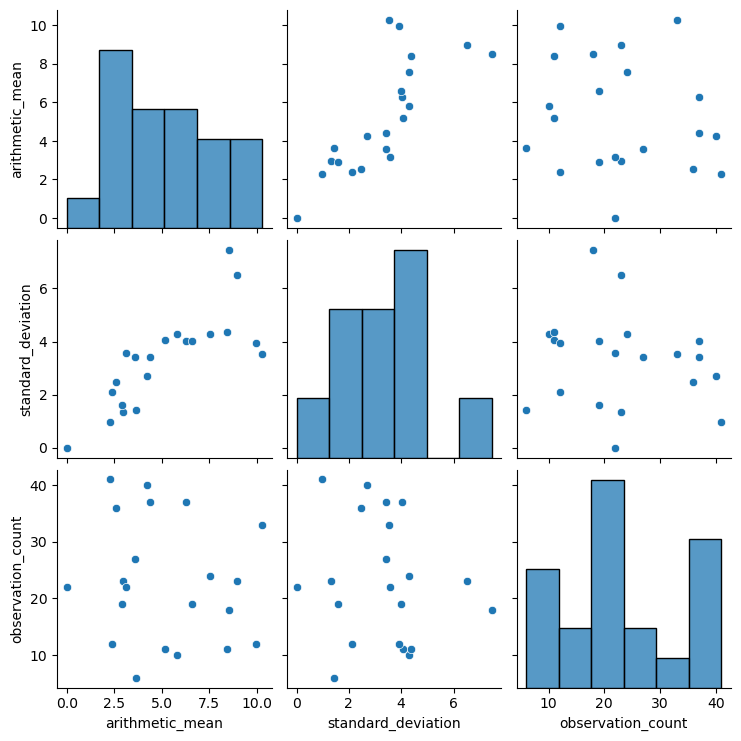

In [222]:
sns.pairplot(dfc[['arithmetic_mean', 'standard_deviation', 'observation_count']])
plt.show()

The above pairplot provides a summary of the relationships between the arithmetic mean, standard deviation and the observation count of the benzene levels.

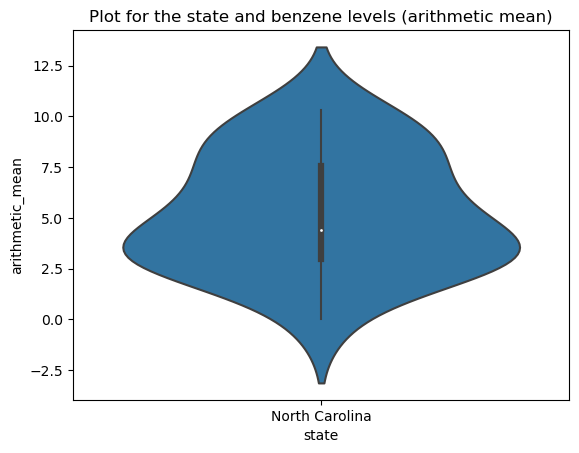

In [223]:
sns.violinplot(x='state', y='arithmetic_mean', data=dfc)
plt.title('Plot for the state and benzene levels (arithmetic mean)')
plt.show()

The above plot helps in understanding the skewness and central tendency of the spread of distribution in the state.

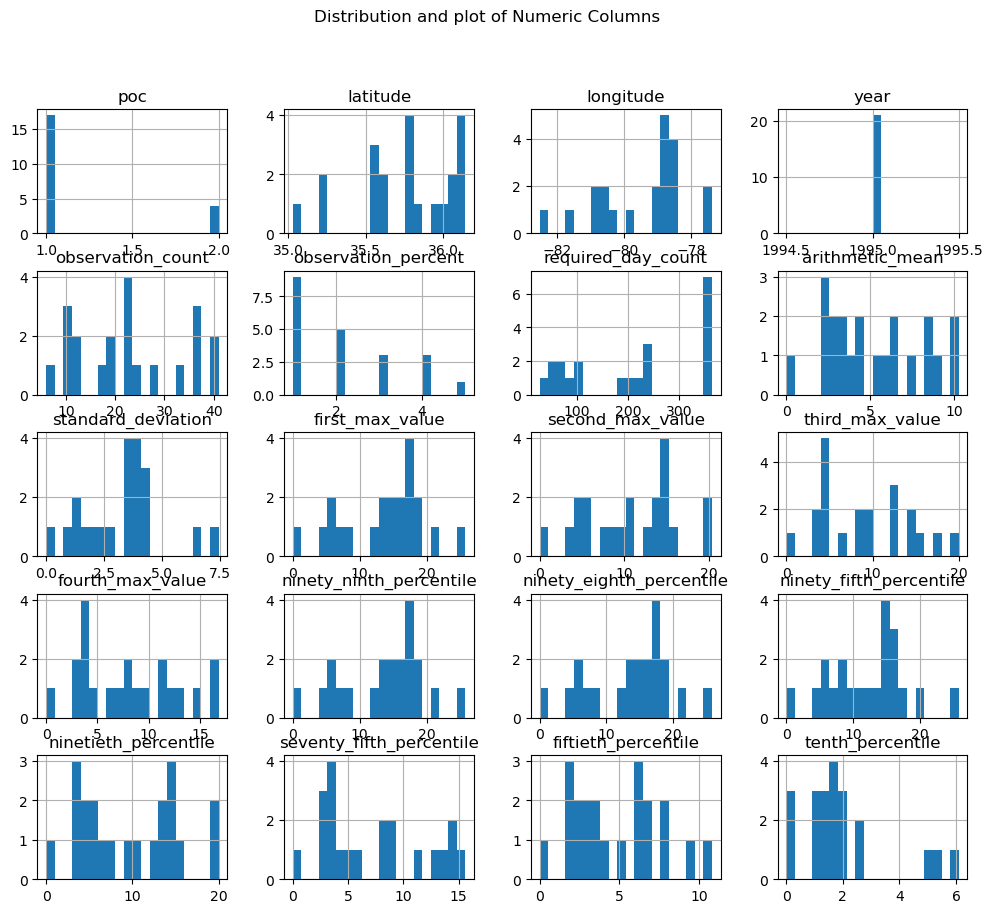

In [224]:
dfc.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distribution and plot of Numeric Columns')
plt.show()

The above plot is used to show the patterns and distribution of numeric values in the dataset.

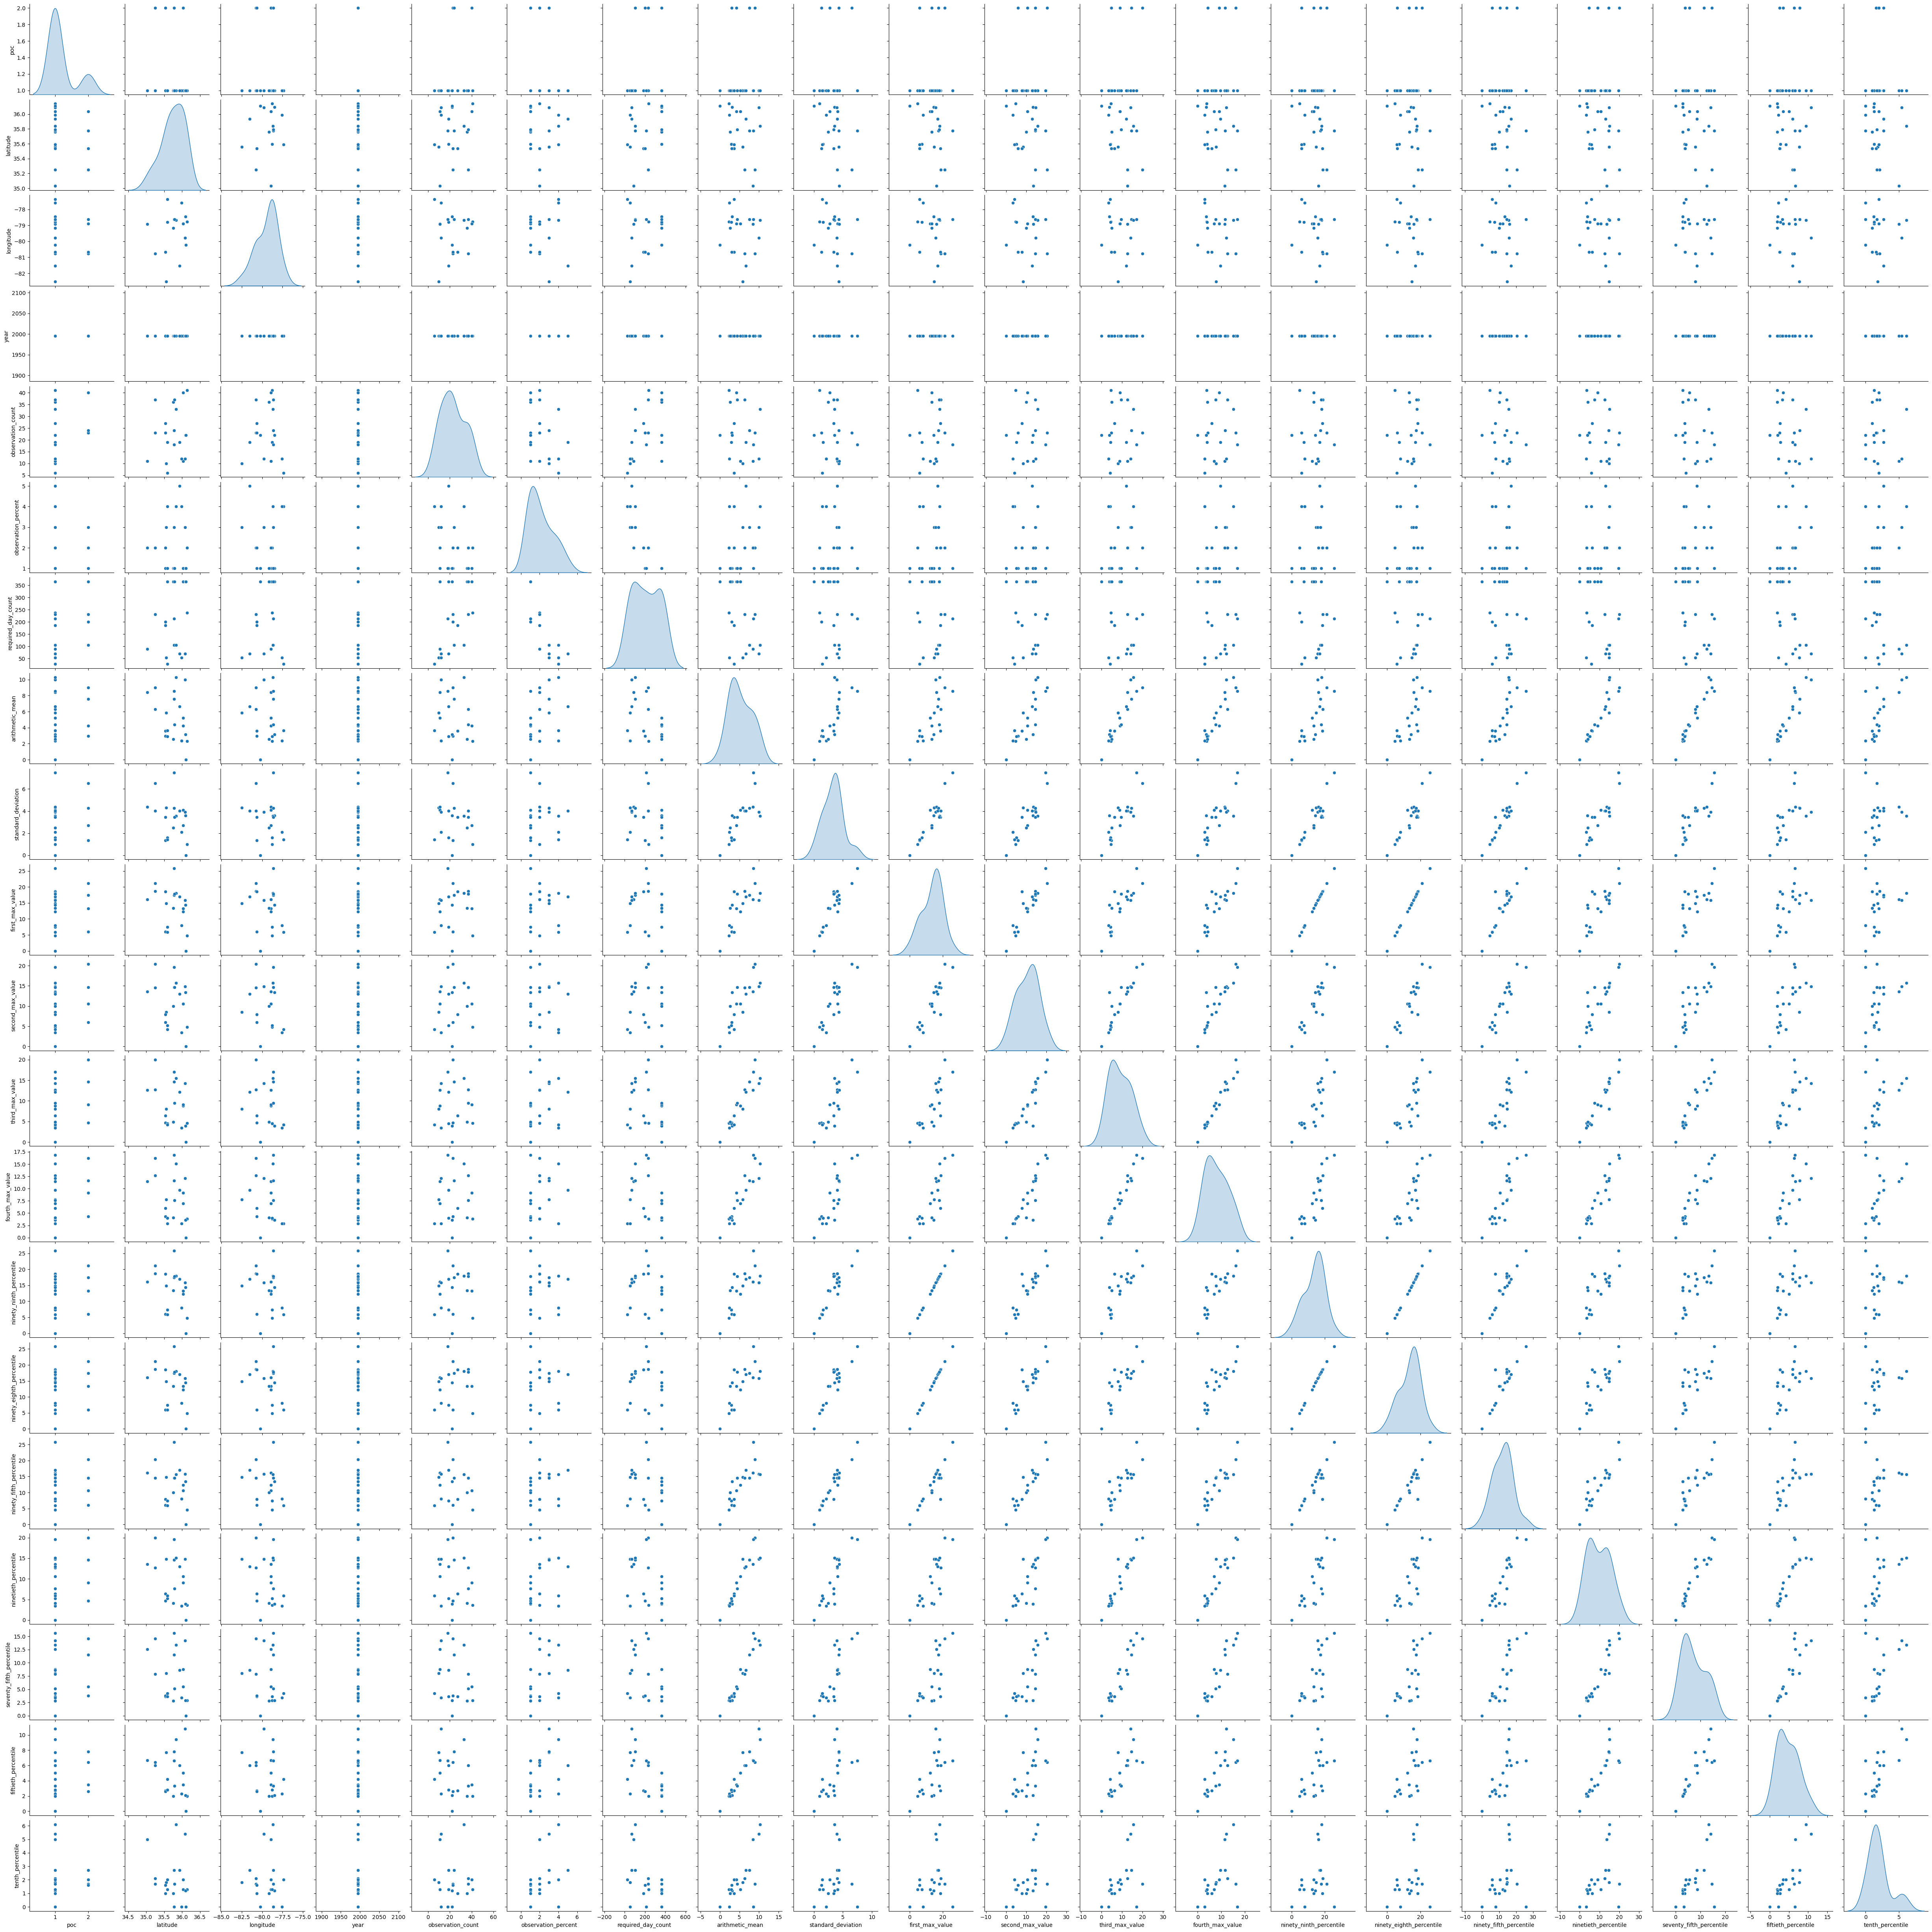

In [225]:
sns.pairplot(dfc, diag_kind='kde')
plt.show()

The above is used to show the relationship between the variables of the dataframe.

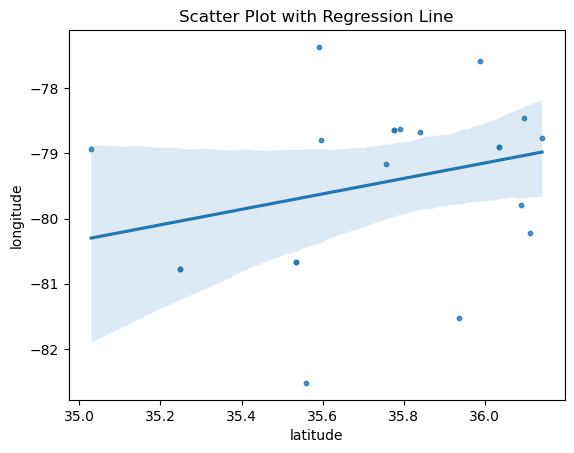

In [226]:
sns.regplot(x='latitude', y='longitude', data=dfc, scatter_kws={'s':10})
plt.title('Scatter Plot with Regression Line')
plt.show()

Since there is a positive correlation depicted in the plot, which suggests that as the latitude and longitude increases the benzene levels do increase too in the state of North Carolina

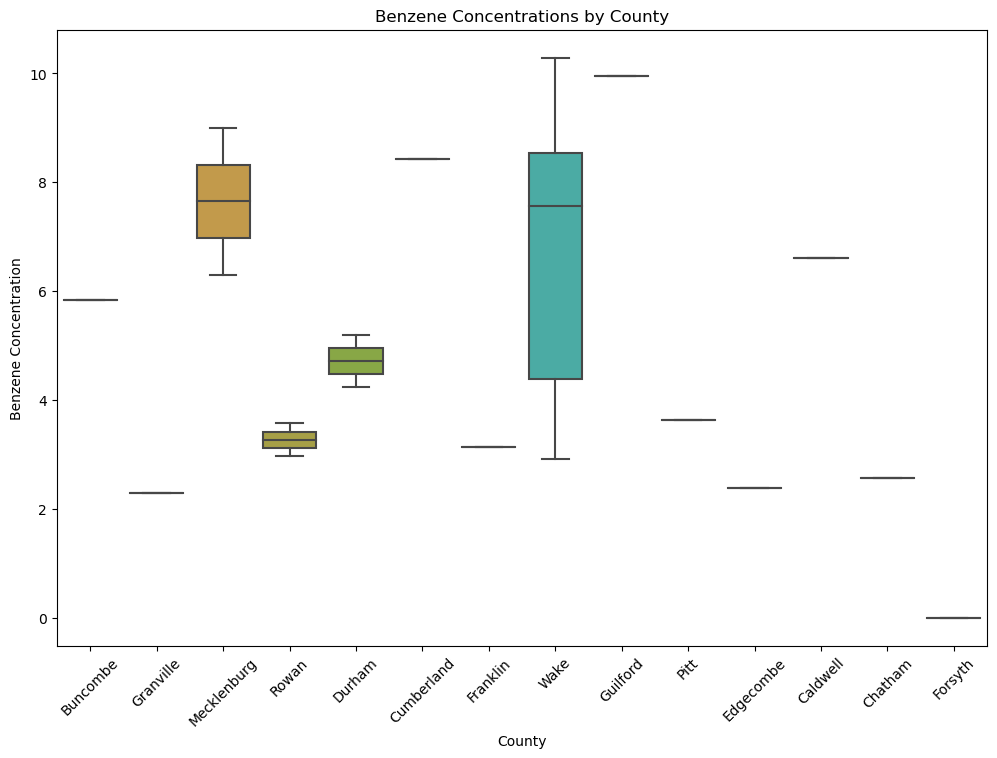

In [227]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='county', y='arithmetic_mean', data=dfc)
plt.title('Benzene Concentrations by County')
plt.xlabel('County')
plt.ylabel('Benzene Concentration')
plt.xticks(rotation=45)
plt.show()


The above plot shows the distribution of benzene level in the air of different counties of the state of North Carolina.

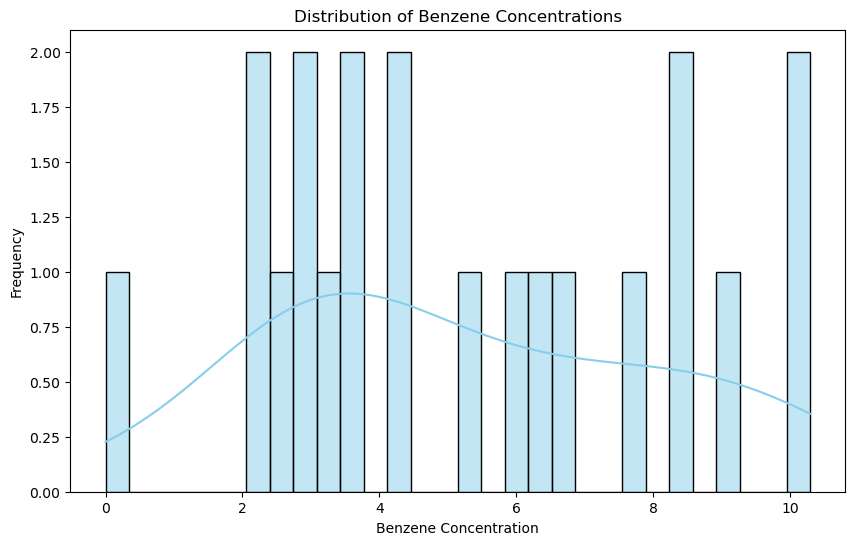

In [228]:
plt.figure(figsize=(10, 6))
sns.histplot(dfc['arithmetic_mean'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Benzene Concentrations')
plt.xlabel('Benzene Concentration')
plt.ylabel('Frequency')
plt.show()

The above plot shows the average distribtuion of benzene levels

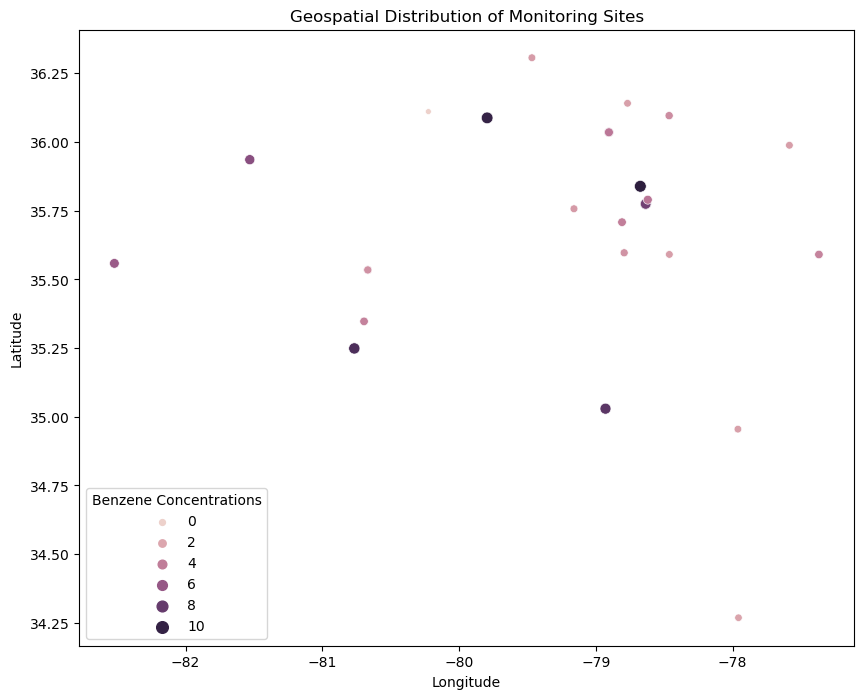

In [229]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', size='arithmetic_mean', hue='arithmetic_mean', data=df)
plt.title('Geospatial Distribution of Monitoring Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Benzene Concentrations')
plt.show()


Benzene concentrations in different parts of the state based on the latitude and longitude.

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\1847804538.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



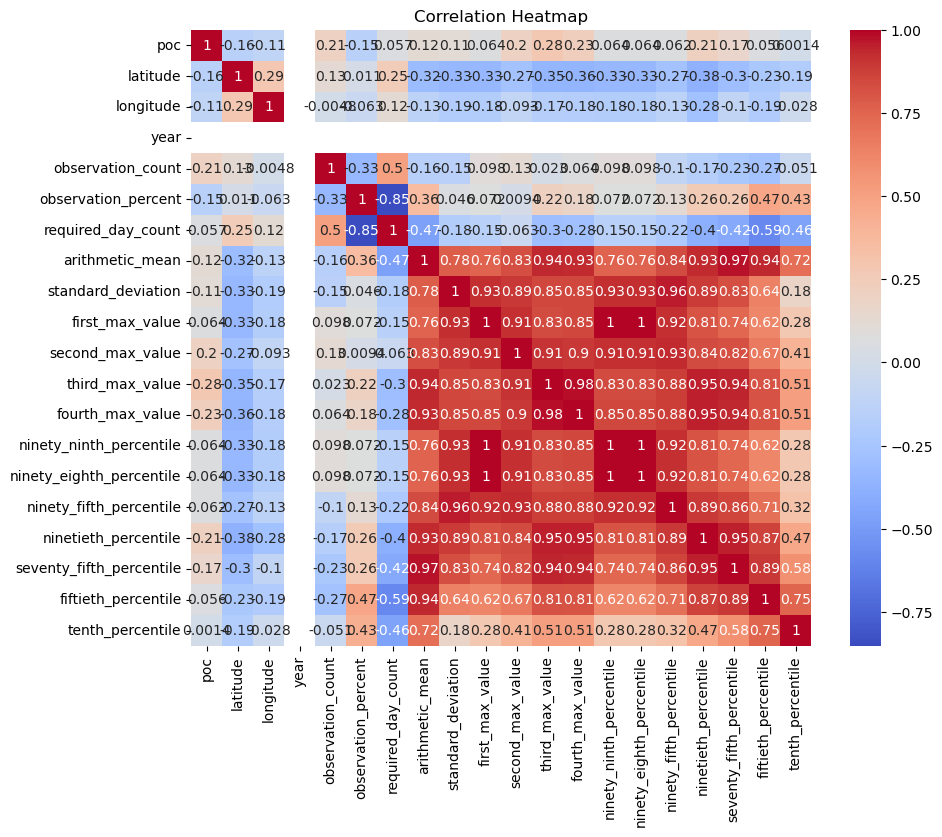

In [230]:
plt.figure(figsize=(10, 8))
correlation_matrix = dfc.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

The above plot shows the correlation of different variables of the dataframe, which can be used to determine the pollution and also help in determining ways to reduce it.

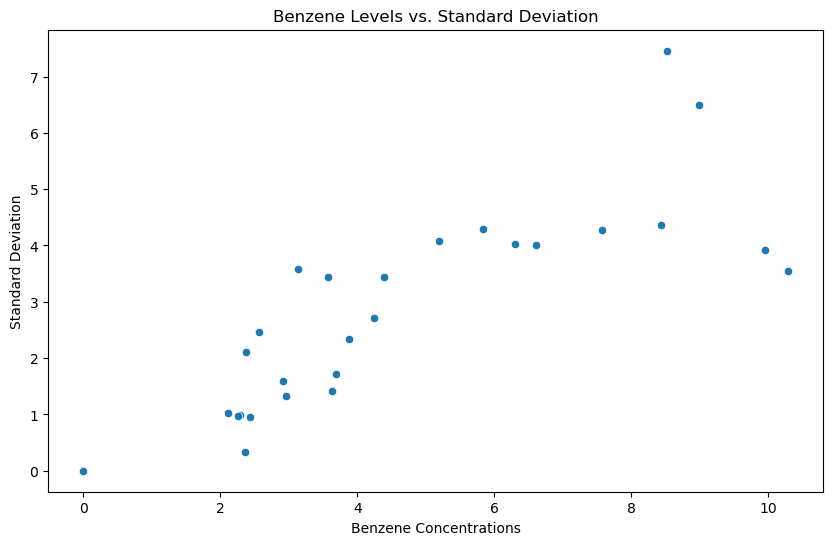

In [231]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='arithmetic_mean', y='standard_deviation', data=df)
plt.title('Benzene Levels vs. Standard Deviation')
plt.xlabel('Benzene Concentrations')
plt.ylabel('Standard Deviation')
plt.show()

The above plot helps in understanding the variability in Benzene levels and whether higher concentrations are associated with greater dispersion as each point on the plot represents a specific monitoring site or instance.

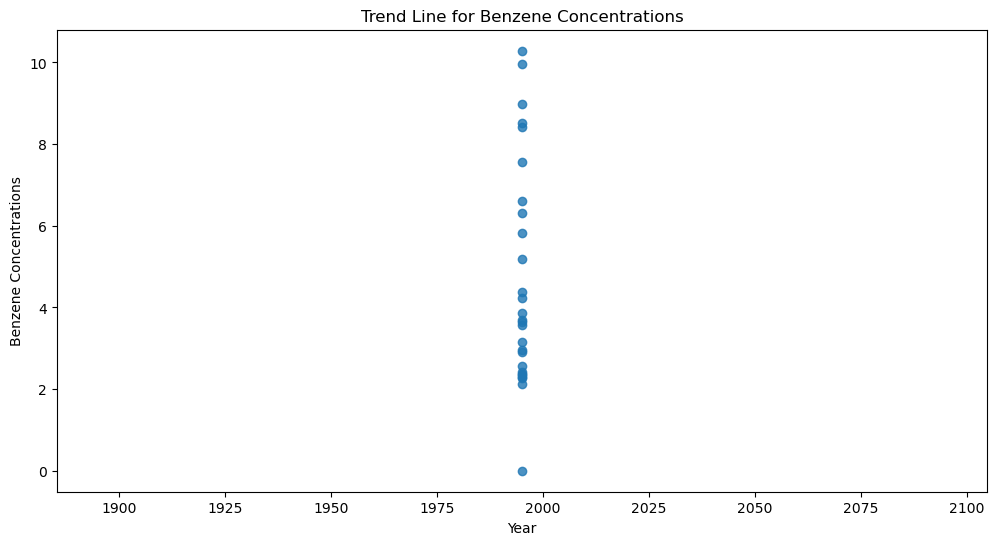

In [232]:
plt.figure(figsize=(12, 6))
sns.regplot(x='year', y='arithmetic_mean', data=df)
plt.title('Trend Line for Benzene Concentrations')
plt.xlabel('Year')
plt.ylabel('Benzene Concentrations')
plt.show()

The overall trend of the above plot shows a decrease in benzene concentration over time. This is a positive finding.

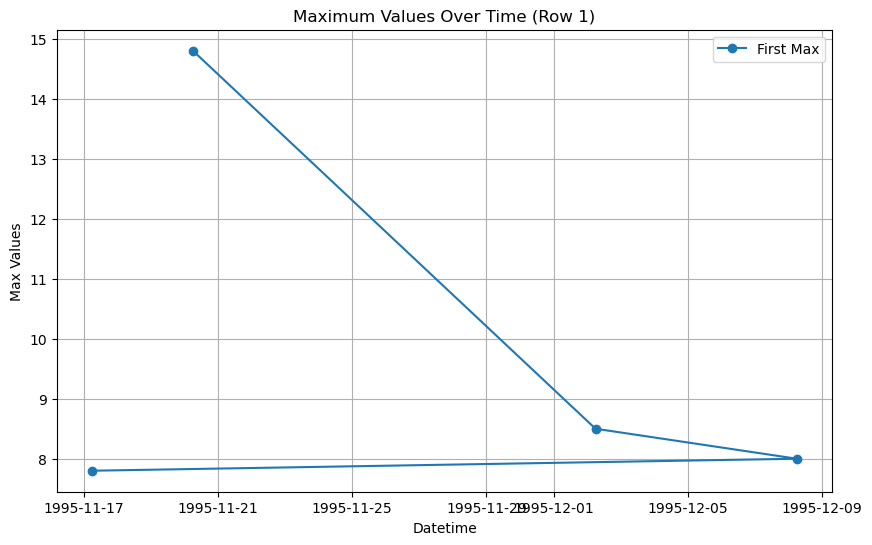

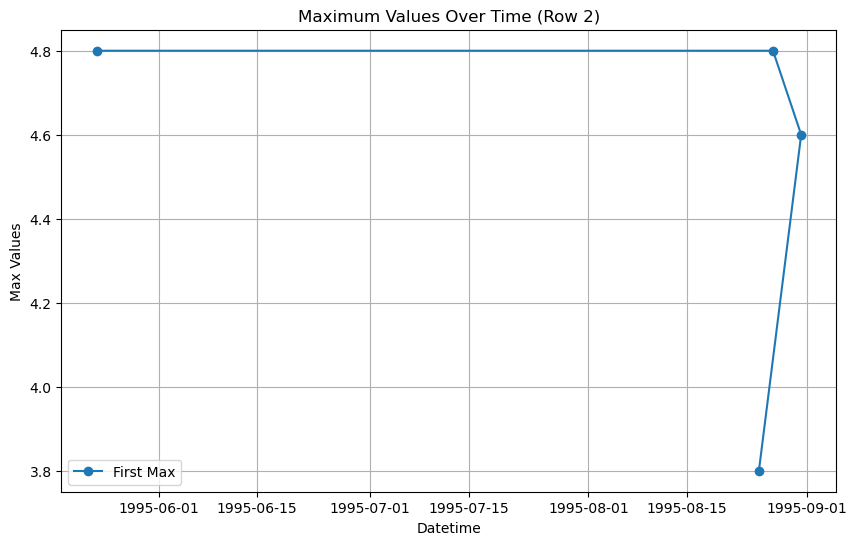

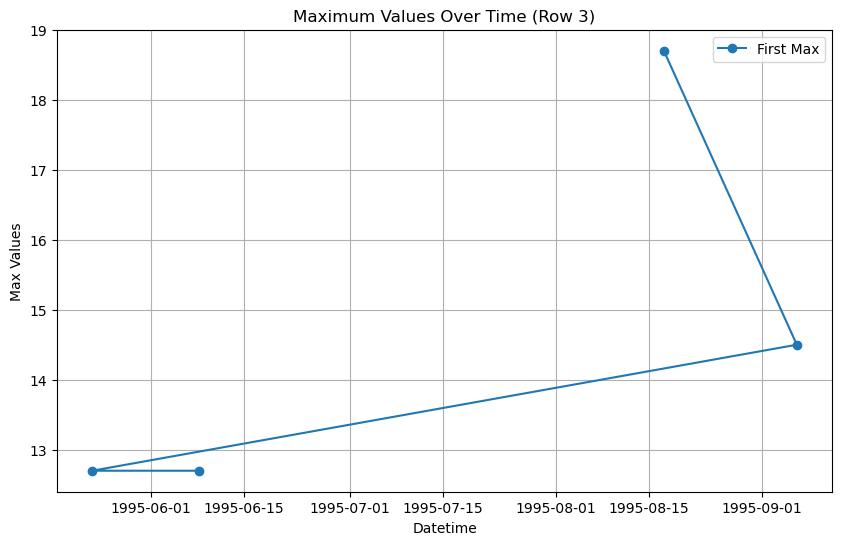

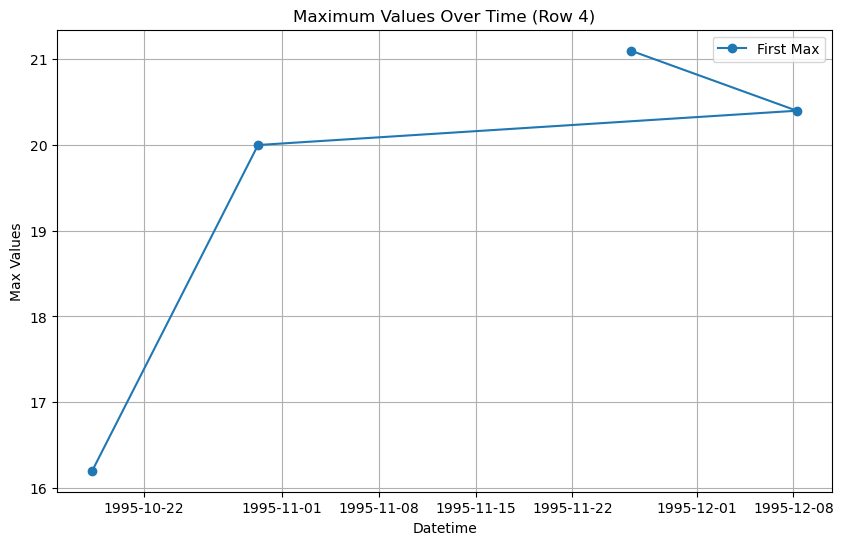

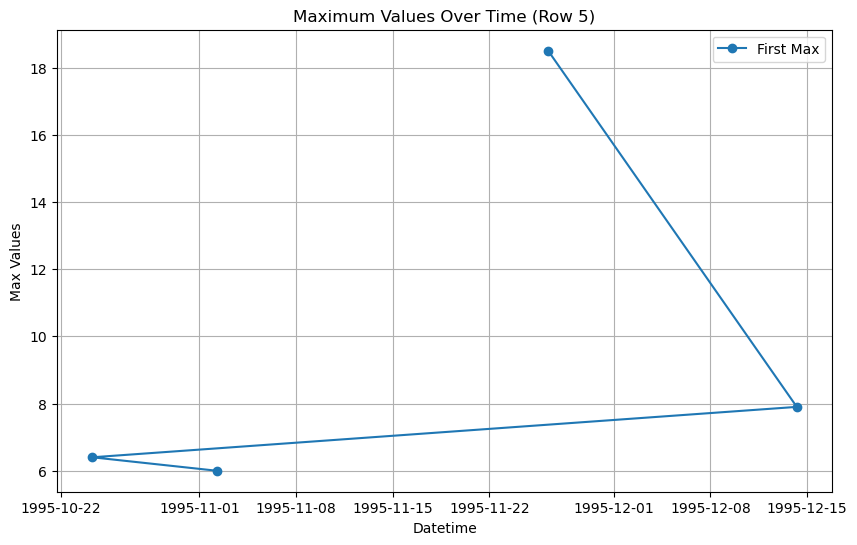

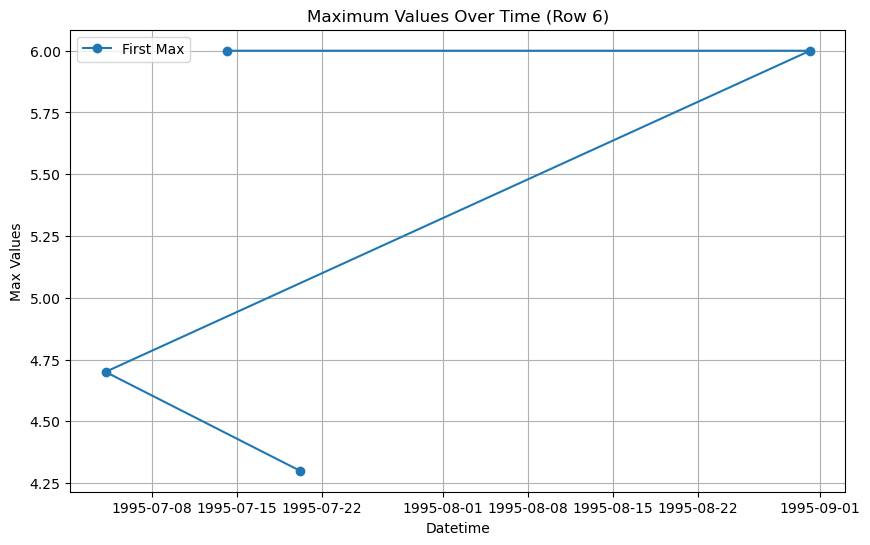

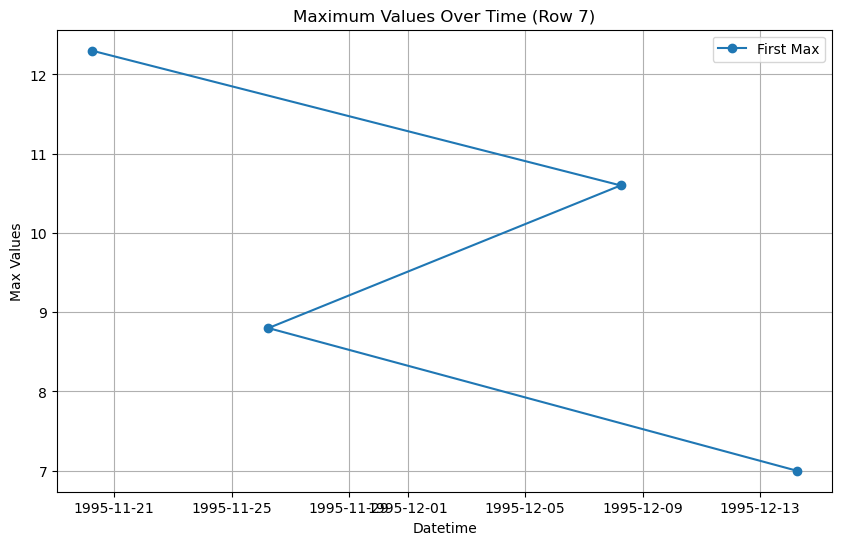

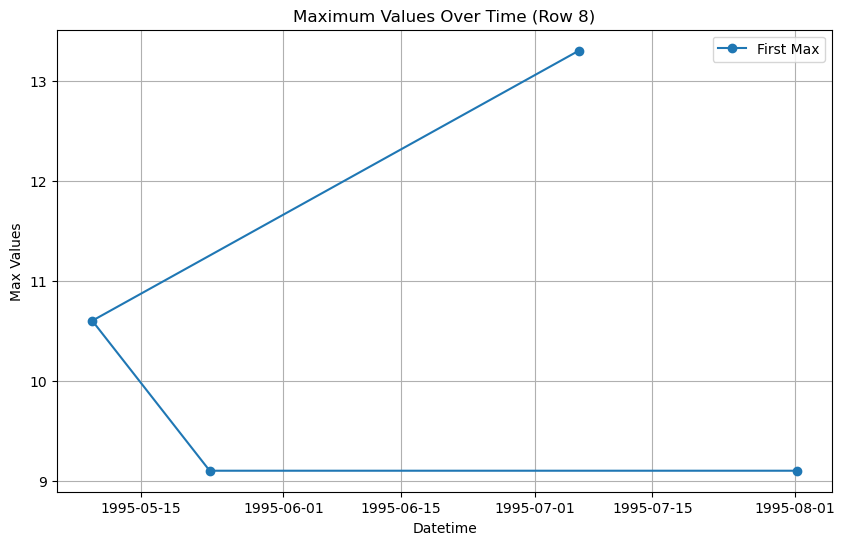

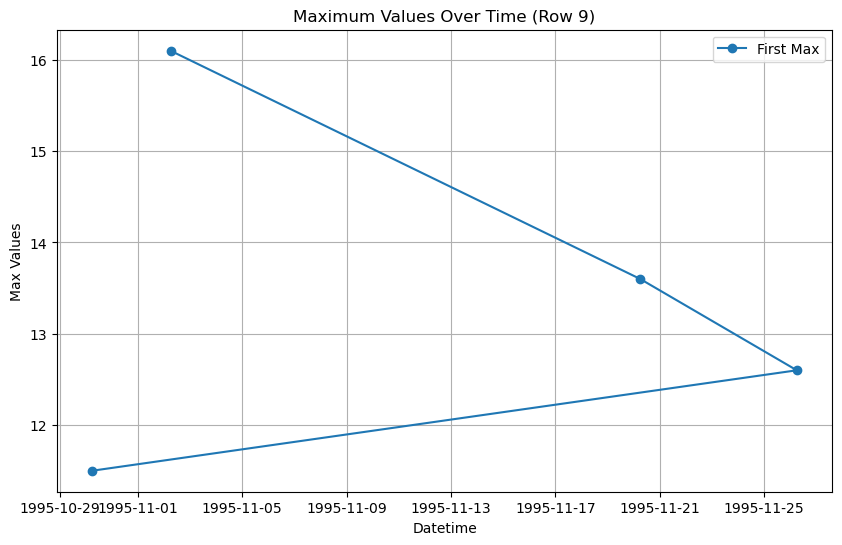

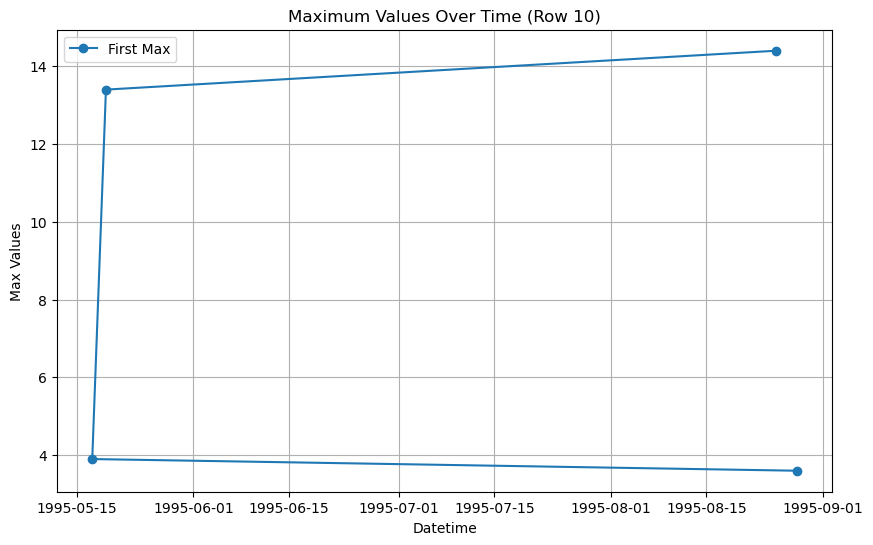

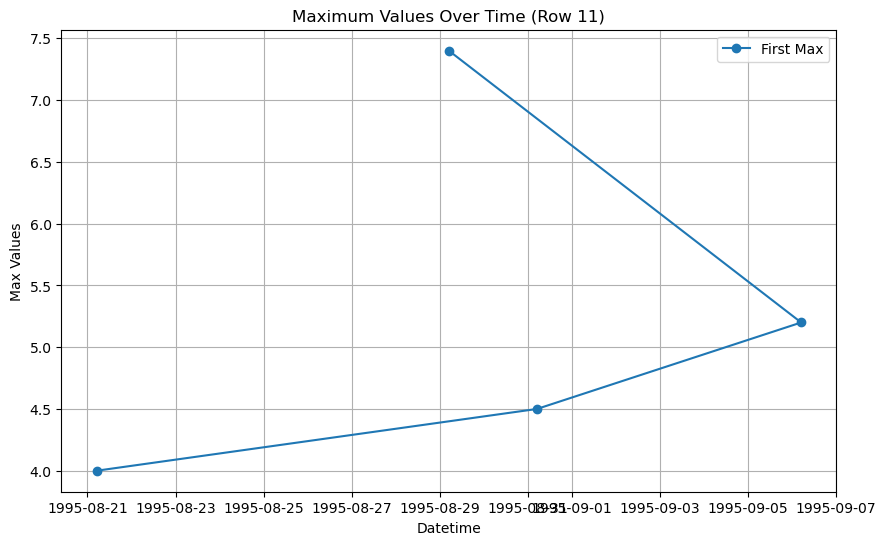

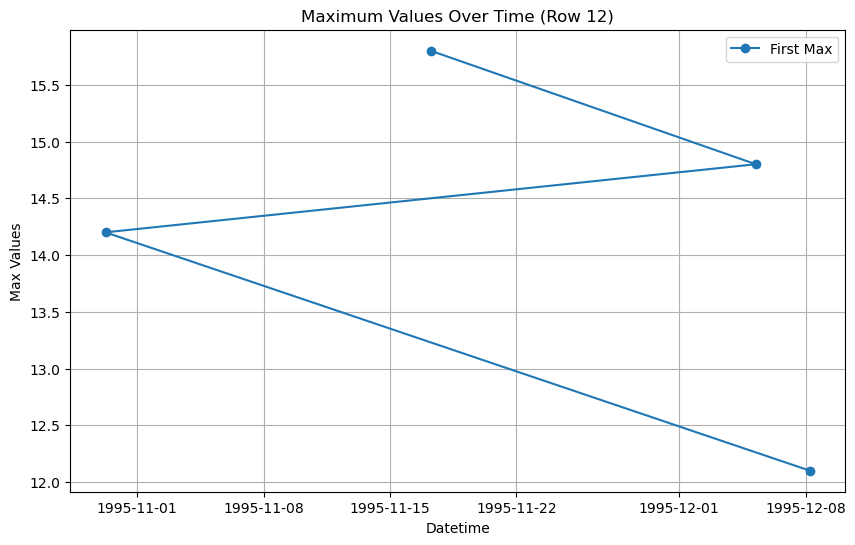

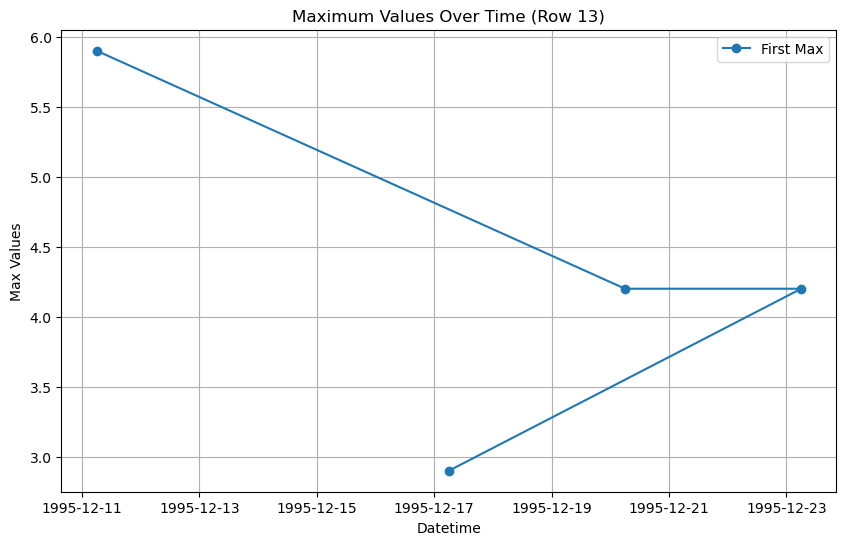

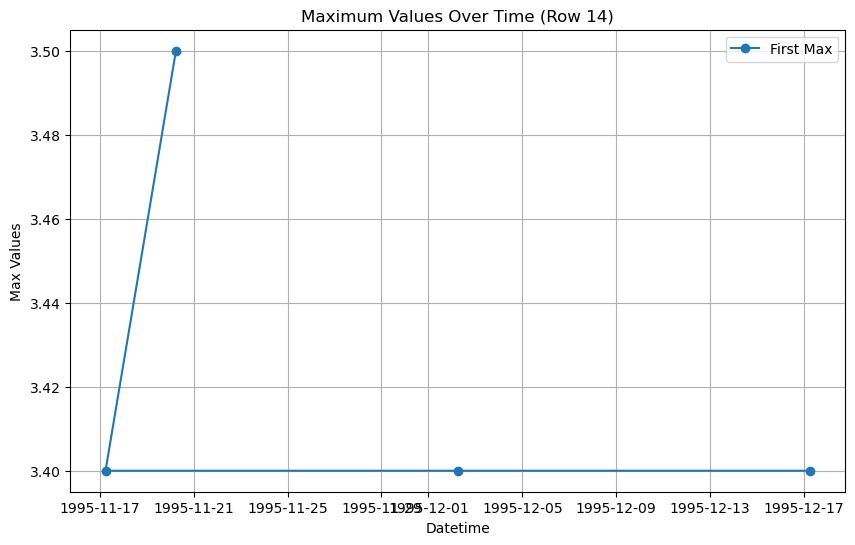

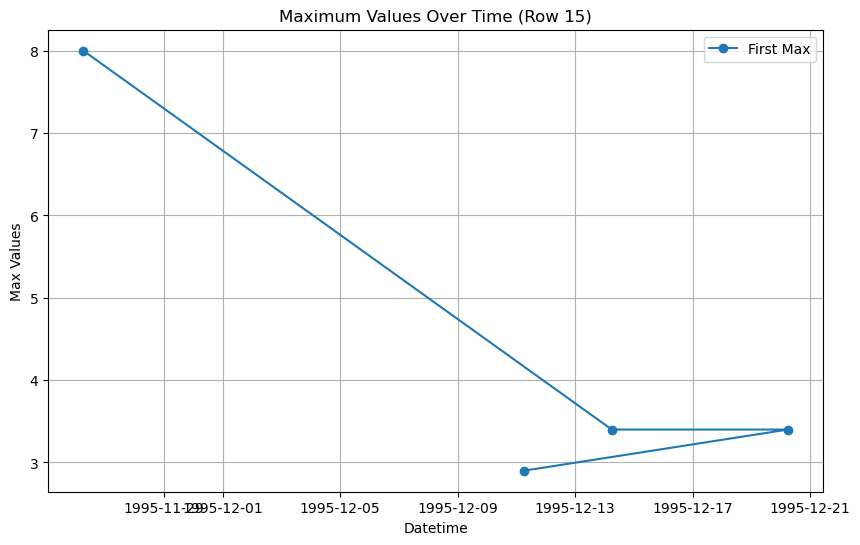

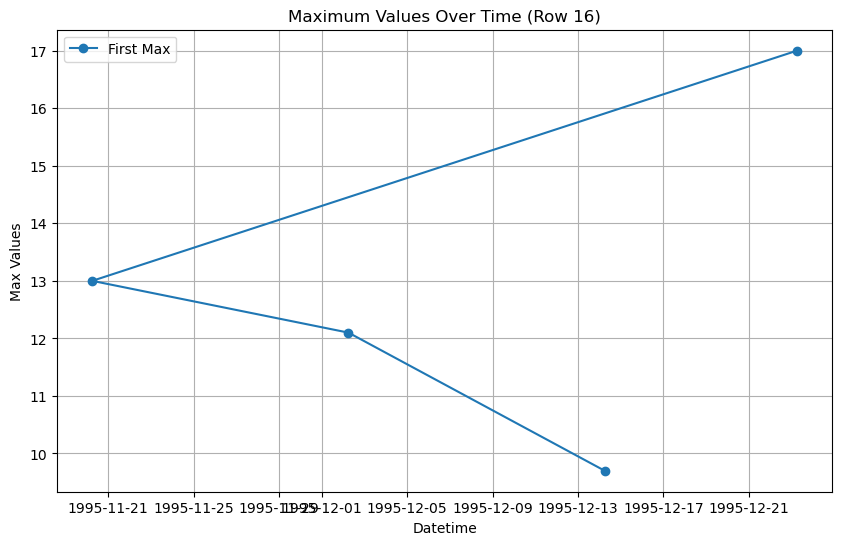

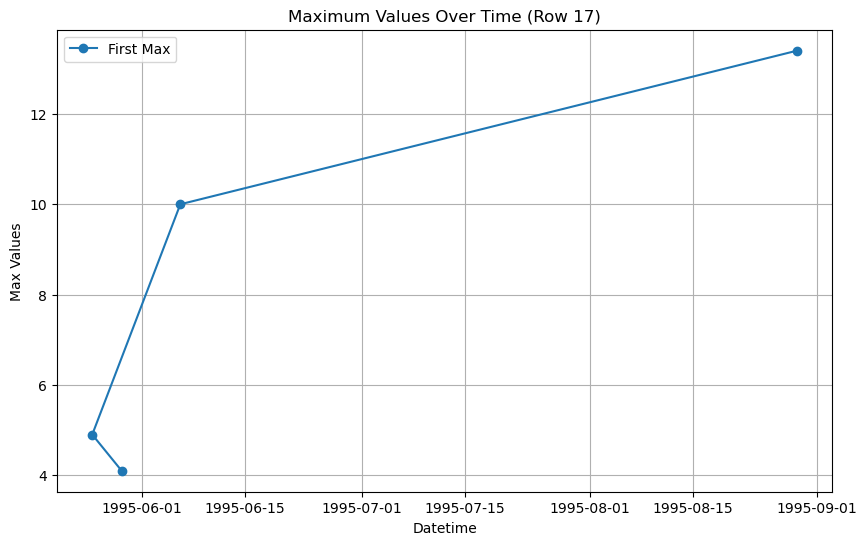

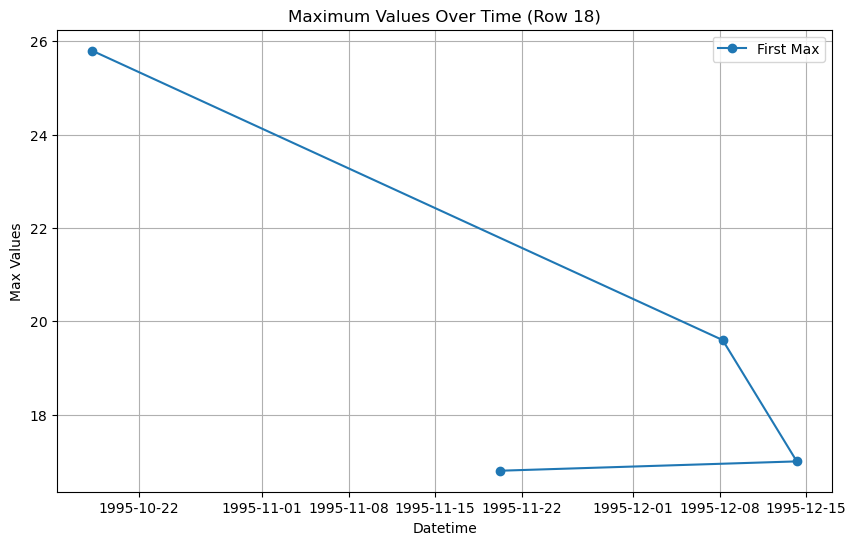

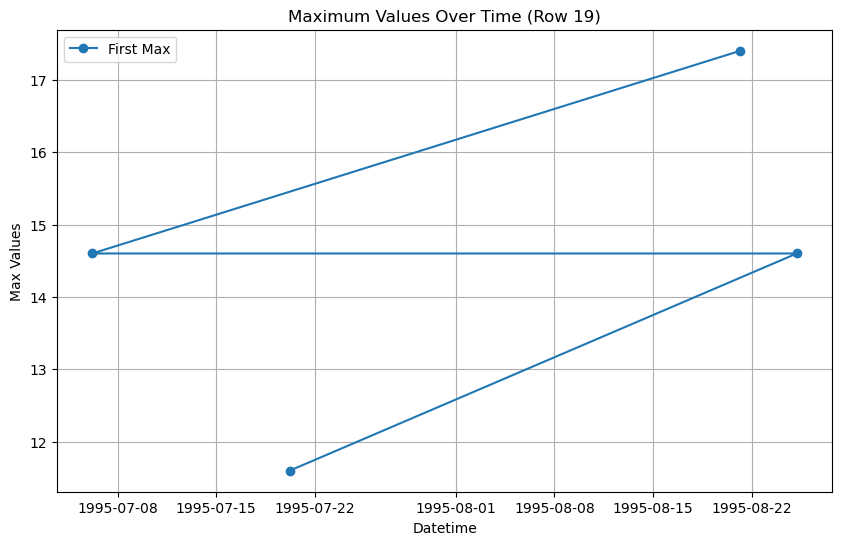

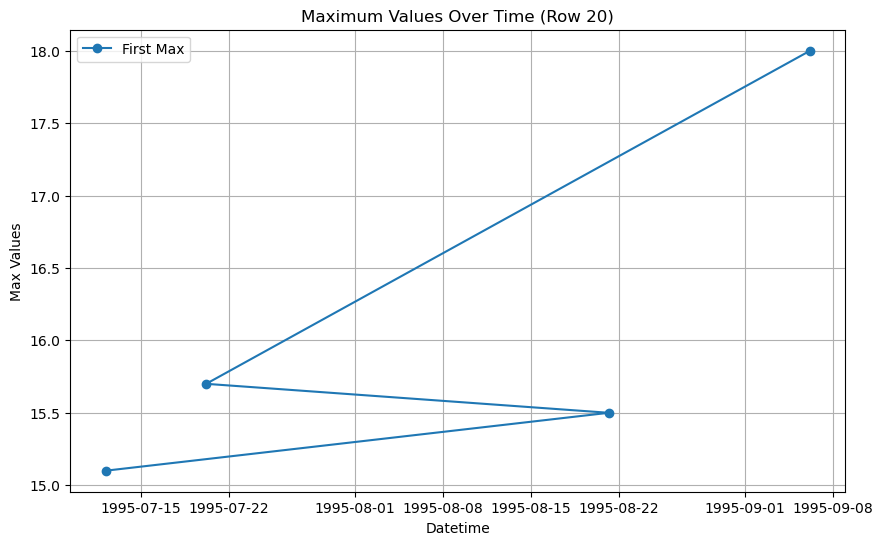

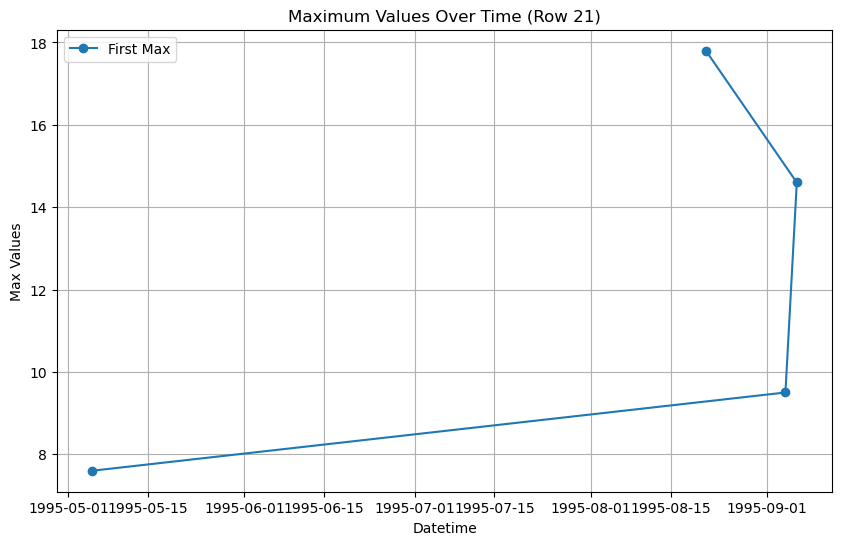

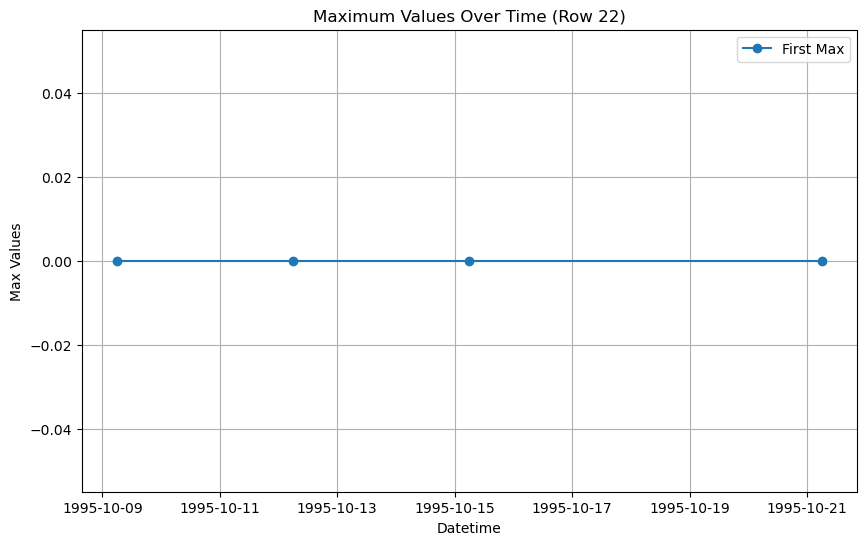

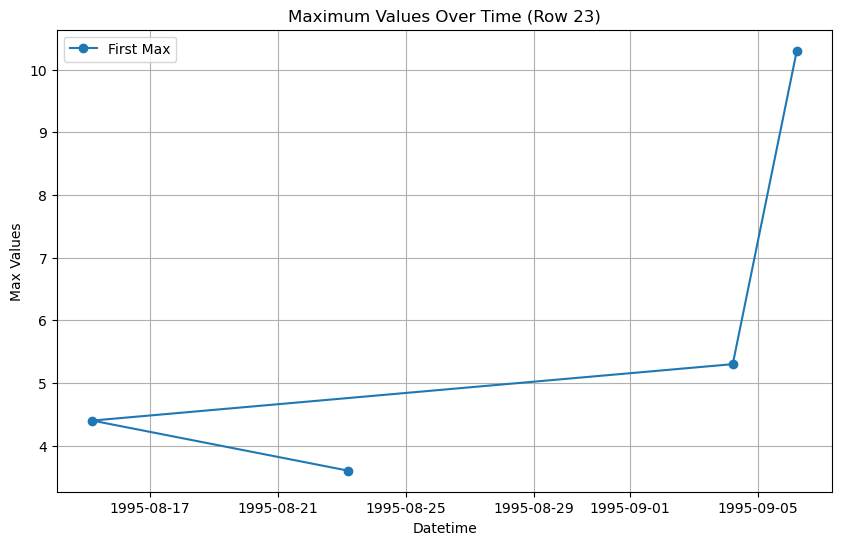

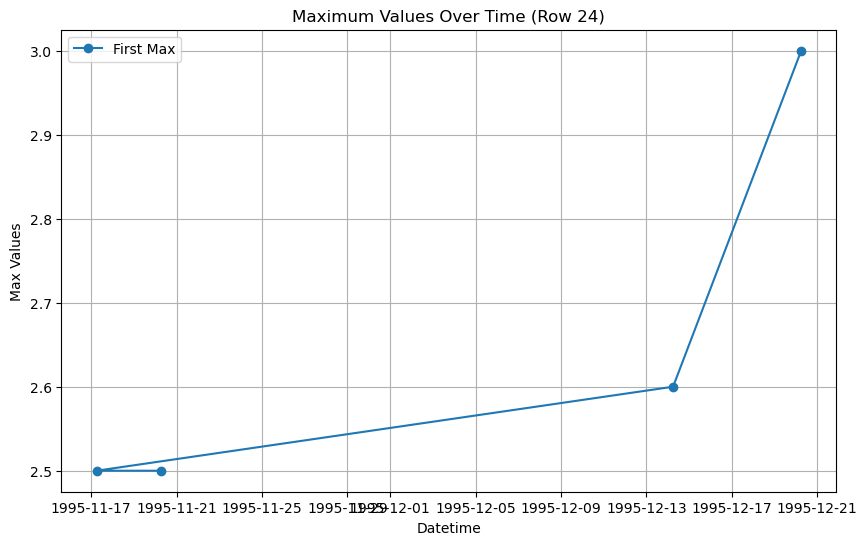

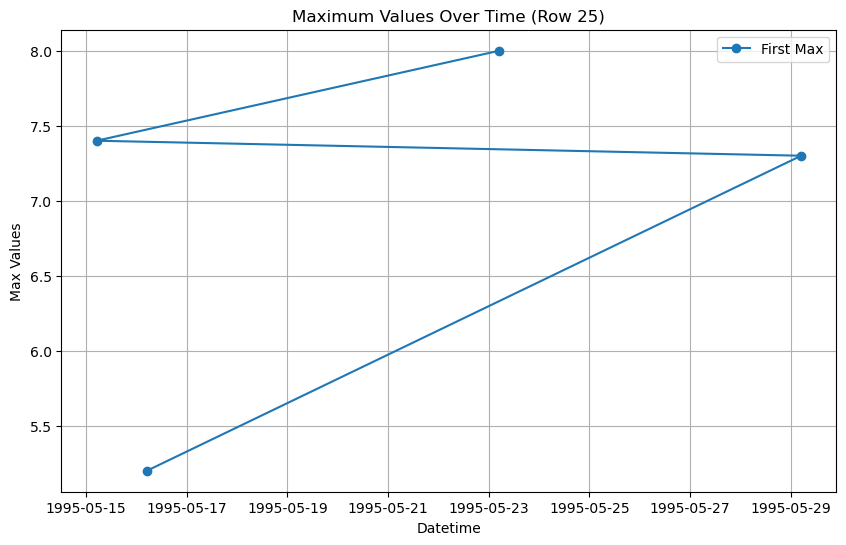

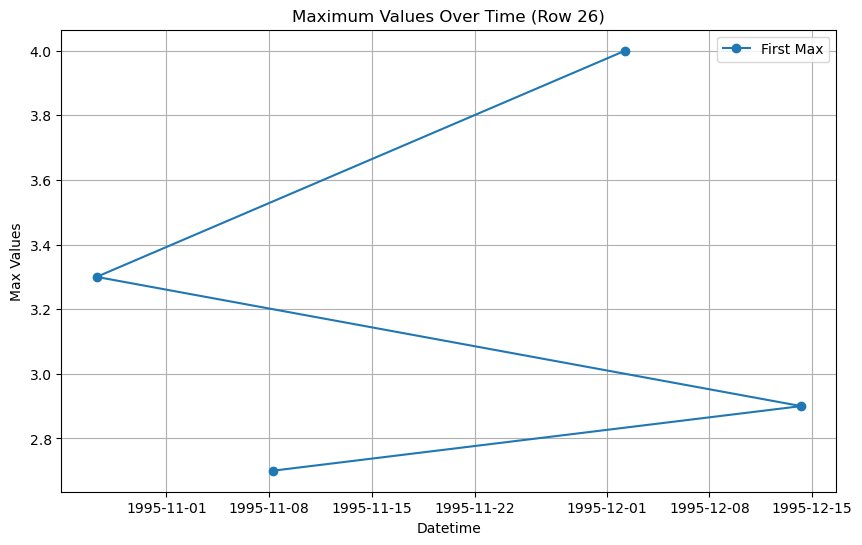

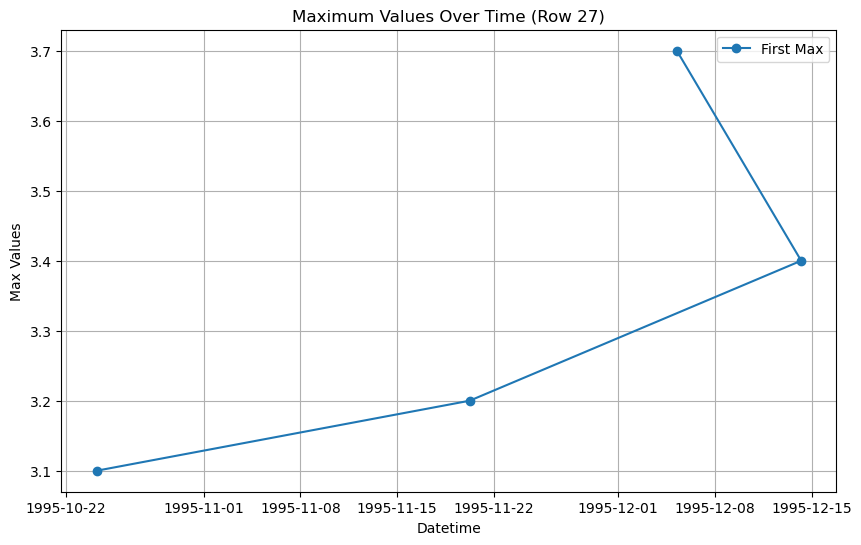

In [233]:
datetime_columns = ['first_max_datetime', 'second_max_datetime', 'third_max_datetime', 'fourth_max_datetime']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col])

for i in range(1, len(datetime_columns)):
    df[f'time_diff_{i}'] = df[datetime_columns[i]] - df[datetime_columns[i - 1]]

for index, row in df.iterrows():
    plt.figure(figsize=(10, 6))
    plt.plot(row[datetime_columns], row[['first_max_value', 'second_max_value', 'third_max_value', 'fourth_max_value']], marker='o')
    plt.title(f'Maximum Values Over Time (Row {index + 1})')
    plt.xlabel('Datetime')
    plt.ylabel('Max Values')
    plt.legend(['First Max', 'Second Max', 'Third Max', 'Fourth Max'])
    plt.grid(True)
    plt.show()

The above plot shows how Benzene concentration changes over time at a specific monitoring site.

## Clustering:

In [234]:
print(dfc.columns)

Index(['state_code', 'county_code', 'site_number', 'parameter_code', 'poc',
       'latitude', 'longitude', 'datum', 'parameter', 'sample_duration_code',
       'sample_duration', 'metric_used', 'method', 'year', 'units_of_measure',
       'event_type', 'observation_count', 'observation_percent',
       'required_day_count', 'arithmetic_mean', 'standard_deviation',
       'first_max_value', 'first_max_datetime', 'second_max_value',
       'second_max_datetime', 'third_max_value', 'third_max_datetime',
       'fourth_max_value', 'fourth_max_datetime', 'ninety_ninth_percentile',
       'ninety_eighth_percentile', 'ninety_fifth_percentile',
       'ninetieth_percentile', 'seventy_fifth_percentile',
       'fiftieth_percentile', 'tenth_percentile', 'site_address', 'state',
       'county', 'city', 'cbsa_code', 'cbsa', 'date_of_last_change'],
      dtype='object')


In [235]:
dfc.head()

state_code county_code site_number parameter_code  poc   latitude  \
0         37         021        0032          45201    1  35.558333   
1         37         077        0001          45201    1  36.141111   
2         37         119        0034          45201    1  35.248754   
3         37         119        0034          45201    2  35.248754   
4         37         159        0022          45201    1  35.534482   

   longitude  datum parameter sample_duration_code  ...  \
0 -82.520833  WGS84   Benzene                    3  ...   
1 -78.768056  WGS84   Benzene                    B  ...   
2 -80.766181  WGS84   Benzene                    B  ...   
3 -80.766181  WGS84   Benzene                    3  ...   
4 -80.667560  WGS84   Benzene                    3  ...   

  seventy_fifth_percentile fiftieth_percentile tenth_percentile  \
0                      8.0                 7.7              1.8   
1                      2.9                 2.0              1.3   
2                      7.9                 6.0              2.1   
3                     14.6                 6.4              1.7   
4                      3.6                 2.7              1.0   

                  site_address           state       county         city  \
0  LONDON RD ASHVILLE NC 28803  North Carolina     Buncombe    Asheville   
1           800 Central Avenue  North Carolina    Granville       Butner   
2      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
3      PLAZA ROAD AND LAKEDELL  North Carolina  Mecklenburg    Charlotte   
4         925 N ENOCHVILLE AVE  North Carolina        Rowan  China Grove   

   cbsa_code                               cbsa  date_of_last_change  
0      11700                      Asheville, NC           2020-05-21  
1      37080                         Oxford, NC           2020-05-21  
2      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
3      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  
4      16740  Charlotte-Concord-Gastonia, NC-SC           2020-05-21  

[5 rows x 43 columns]

### K-Means, Elbow and Silhouette

In [236]:
d = dfc[['latitude', 'longitude', 'arithmetic_mean']]
d.head()

latitude  longitude  arithmetic_mean
0  35.558333 -82.520833         5.830000
1  36.141111 -78.768056         2.285366
2  35.248754 -80.766181         6.302703
3  35.248754 -80.766181         8.986957
4  35.534482 -80.667560         3.566667

In [237]:
inertia = []

In [238]:
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(d)
    inertia.append(kmeans.inertia_)

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\c

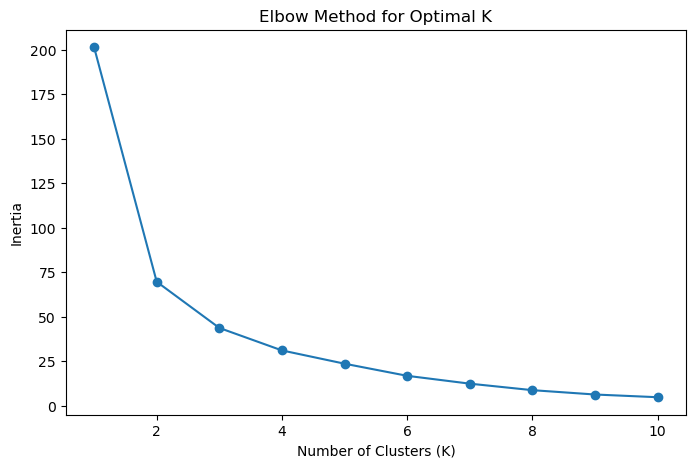

In [239]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

In [240]:
crange = range(2, 11)
scores = []

for num_clusters in crange:
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(d)
    
    values = silhouette_samples(d, kmeans.labels_)
    
    average_score = silhouette_score(d, kmeans.labels_)
    
    scores.append(average_score)

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\c

In [241]:
scores

[0.5373567994923705,
 0.5022043220926108,
 0.4401041780665577,
 0.4358902296697211,
 0.4750399281435352,
 0.42470198716969226,
 0.442545869045189,
 0.43977868567028366,
 0.39718819722906823]

In [242]:
average_score

0.39718819722906823

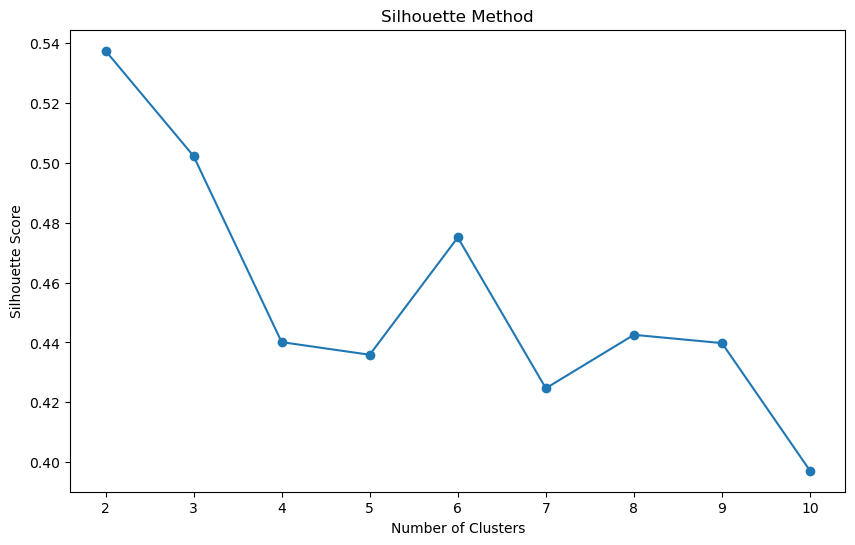

In [243]:
plt.figure(figsize=(10, 6))
plt.plot(crange, scores, marker='o')
plt.title('Silhouette Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [244]:
#kmeans = KMeans(n_clusters=3).fit(dfc[['latitude', 'longitude', 'arithmetic_mean']])
kmeans = KMeans(n_clusters=2).fit(d)
d['kmeans_cluster'] = kmeans.labels_

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\2181919726.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [245]:
kmeans

KMeans(n_clusters=2)

In [246]:
d['kmeans_cluster']

0     1
1     0
2     1
3     1
4     0
5     0
6     0
7     0
8     1
9     0
10    0
11    1
12    0
14    0
15    1
16    0
17    1
18    1
19    1
20    0
21    0
Name: kmeans_cluster, dtype: int32

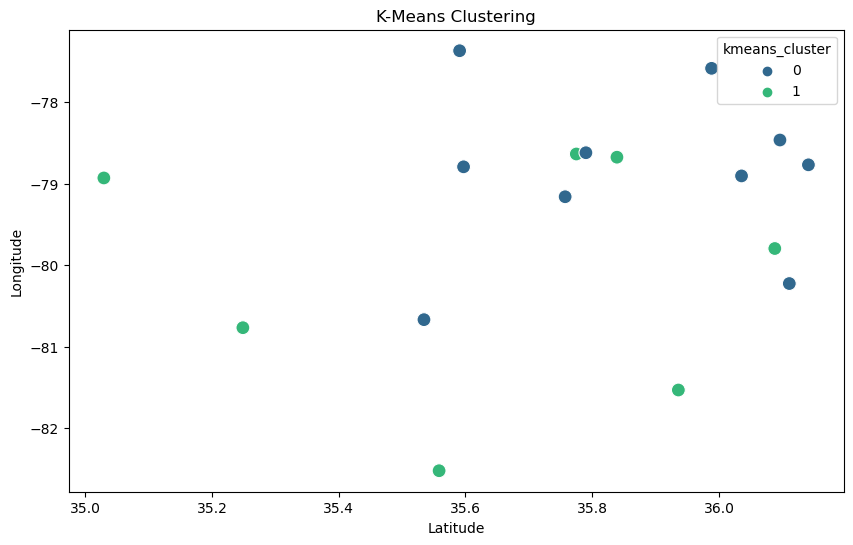

In [247]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d, palette='viridis', s=100)
plt.title('K-Means Clustering')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [248]:
print(d[['latitude', 'longitude', 'arithmetic_mean', 'kmeans_cluster']])

     latitude  longitude  arithmetic_mean  kmeans_cluster
0   35.558333 -82.520833         5.830000               1
1   36.141111 -78.768056         2.285366               0
2   35.248754 -80.766181         6.302703               1
3   35.248754 -80.766181         8.986957               1
4   35.534482 -80.667560         3.566667               0
5   35.534482 -80.667560         2.960870               0
6   36.035556 -78.904167         5.190909               0
7   36.035556 -78.904167         4.237500               0
8   35.029403 -78.929234         8.427273               1
9   36.096189 -78.463719         3.140909               0
10  35.596944 -78.792500         2.910526               0
11  36.088072 -79.794733         9.958333               1
12  35.590717 -77.368298         3.633333               0
14  35.988278 -77.584300         2.375000               0
15  35.935900 -81.530600         6.610526               1
16  35.757222 -79.159722         2.569444               0
17  35.774875 

In [249]:
print(d['kmeans_cluster'].value_counts())


0    12
1     9
Name: kmeans_cluster, dtype: int64


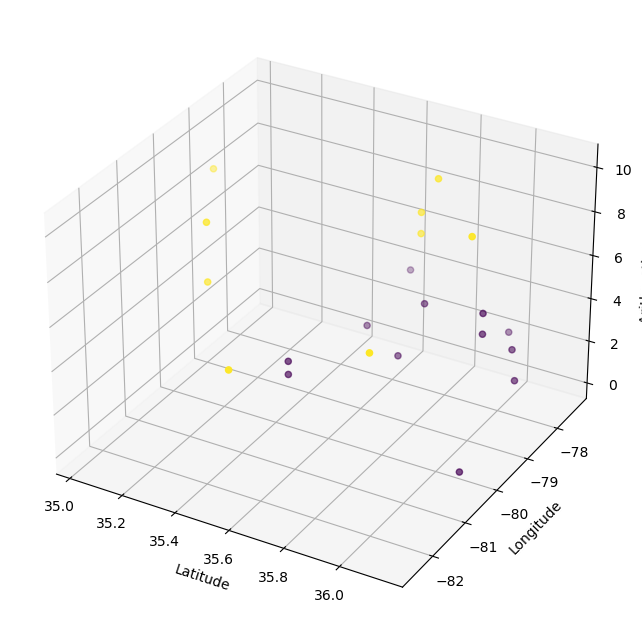

In [250]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(d['latitude'], d['longitude'], d['arithmetic_mean'], c=d['kmeans_cluster'], marker='o')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Arithmetic Mean')
plt.show()


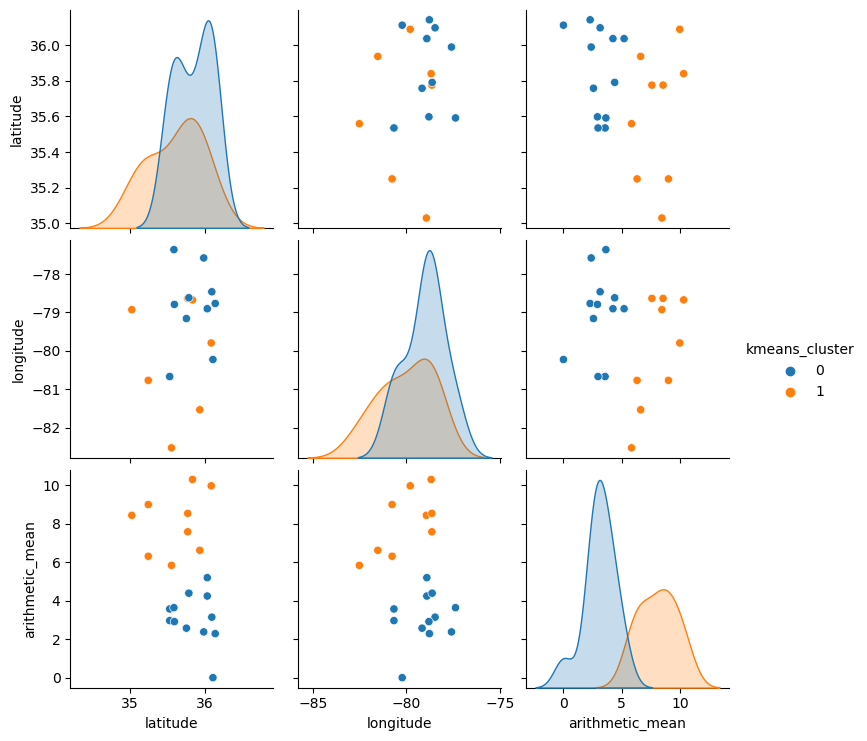

In [251]:
sns.pairplot(d, hue='kmeans_cluster', diag_kind='kde')
plt.show()


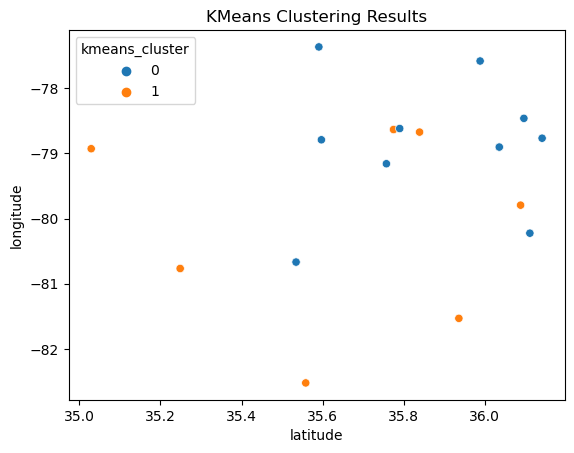

In [252]:
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d)
plt.title('KMeans Clustering Results')
plt.show()

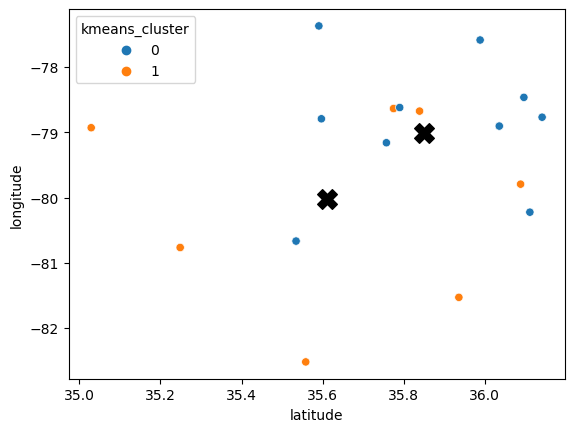

In [253]:
centroids = kmeans.cluster_centers_
sns.scatterplot(x='latitude', y='longitude', hue='kmeans_cluster', data=d)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, color='black', label='Centroids')
plt.show()

In [254]:
centroids

array([[ 35.85095833, -79.01035608,   3.10475083],
       [ 35.61088267, -80.028067  ,   8.05580911]])

In [255]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(d)
d['dbscan_cluster'] = dbscan.labels_

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\4146417925.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [256]:
d['dbscan_cluster']

0    -1
1    -1
2    -1
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10   -1
11   -1
12   -1
14   -1
15   -1
16   -1
17   -1
18   -1
19   -1
20   -1
21   -1
Name: dbscan_cluster, dtype: int64

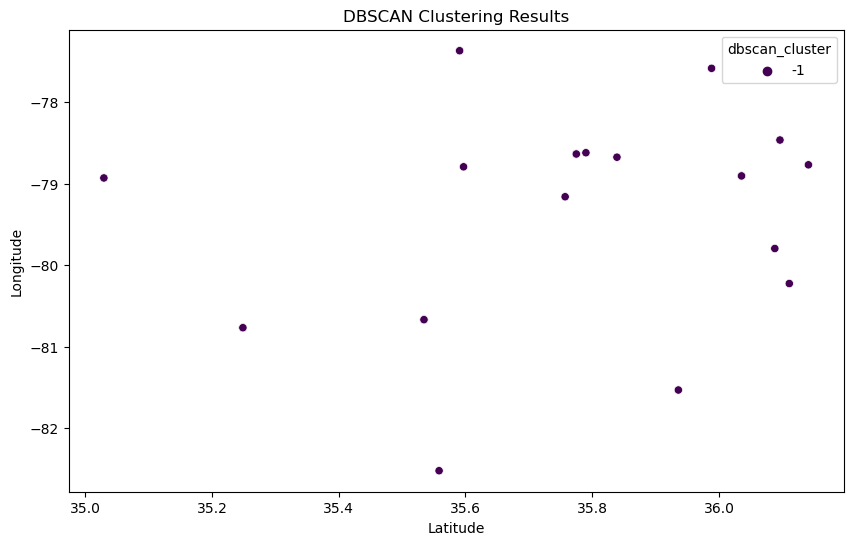

In [257]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='latitude', y='longitude', hue='dbscan_cluster', data=d, palette='viridis', legend='full')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

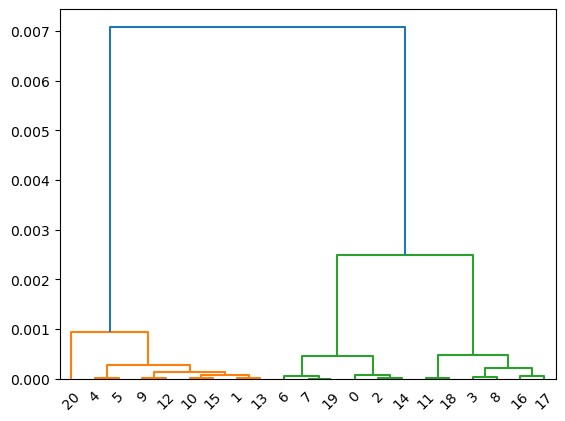

In [258]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(d, method='complete', metric='cosine'))

Euclidean Distance:
Euclidean distance measures the straight-line distance between two points in Euclidean space.
$$ Formula: d(x, y) = \sum_{i=1}^{n}(x_i - y_i)^2 $$

Manhattan Distance:
Manhattan distance calculates the distance by summing the absolute differences between corresponding coordinates.
$$ Formula: d(x, y) = \sum_{i=1}^{n} |x_i - y_i| $$

Cosine Similarity:
Cosine similarity measures the cosine of the angle between two vectors and is particularly useful for text or high-dimensional data.
$$ Formula: (x,y) = \frac{x.y}{||x||.||y||}$$ 

In [259]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.tree import plot_tree
import plotly.express as px
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go

In [260]:
label_encoders = {}
for column in ['state', 'county', 'city', 'parameter']:
    le = LabelEncoder()
    dfc[column] = le.fit_transform(dfc[column])
    label_encoders[column] = le

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\3776891108.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\3776891108.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\3776891108.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [261]:
threshold = dfc['arithmetic_mean'].quantile(0.75)  
dfc['air_quality'] = (dfc['arithmetic_mean'] > threshold).astype(int)

C:\Users\choks\AppData\Local\Temp\ipykernel_25068\3341165043.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [262]:
threshold

7.570833

In [263]:
dfc['air_quality']

0     0
1     0
2     0
3     1
4     0
5     0
6     0
7     0
8     1
9     0
10    0
11    1
12    0
14    0
15    0
16    0
17    1
18    0
19    1
20    0
21    0
Name: air_quality, dtype: int32

In [264]:
X = dfc[['state', 'county', 'city', 'parameter', 'year']]
y = dfc['air_quality']

In [265]:
X.head()

state  county  city  parameter  year
0      0       0     0          0  1995
1      0       8     1          0  1995
2      0      10     2          0  1995
3      0      10     2          0  1995
4      0      12     3          0  1995

In [266]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
X_train, X_test, y_train, y_test

(    state  county  city  parameter  year
 5       0      12     3          0  1995
 11      0       9     8          0  1995
 3       0      10     2          0  1995
 19      0      13    13          0  1995
 17      0      13    13          0  1995
 14      0       5    10          0  1995
 2       0      10     2          0  1995
 9       0       7     6          0  1995
 21      0       6    14          0  1995
 4       0      12     3          0  1995
 12      0      11     9          0  1995
 7       0       4     4          0  1995
 10      0      13     7          0  1995
 15      0       1    11          0  1995
 20      0      13    13          0  1995
 6       0       4     4          0  1995,
     state  county  city  parameter  year
 0       0       0     0          0  1995
 18      0      13    13          0  1995
 16      0       2    12          0  1995
 1       0       8     1          0  1995
 8       0       3     5          0  1995,
 5     0
 11    1
 3     1
 19  

In [268]:
X_train

state  county  city  parameter  year
5       0      12     3          0  1995
11      0       9     8          0  1995
3       0      10     2          0  1995
19      0      13    13          0  1995
17      0      13    13          0  1995
14      0       5    10          0  1995
2       0      10     2          0  1995
9       0       7     6          0  1995
21      0       6    14          0  1995
4       0      12     3          0  1995
12      0      11     9          0  1995
7       0       4     4          0  1995
10      0      13     7          0  1995
15      0       1    11          0  1995
20      0      13    13          0  1995
6       0       4     4          0  1995

In [269]:
X_test

state  county  city  parameter  year
0       0       0     0          0  1995
18      0      13    13          0  1995
16      0       2    12          0  1995
1       0       8     1          0  1995
8       0       3     5          0  1995

In [270]:
y_train

5     0
11    1
3     1
19    1
17    1
14    0
2     0
9     0
21    0
4     0
12    0
7     0
10    0
15    0
20    0
6     0
Name: air_quality, dtype: int32

In [271]:
y_test

0     0
18    0
16    0
1     0
8     1
Name: air_quality, dtype: int32

In [272]:
gnb = GaussianNB()

In [273]:
gnb.fit(X_train, y_train)

GaussianNB()

In [274]:
y_pred = gnb.predict(X_test)

In [275]:
y_pred

array([0, 1, 0, 0, 0])

In [276]:
print("Naive Bayes Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Naive Bayes Classifier Accuracy: 0.6
Confusion Matrix:
 [[3 1]
 [1 0]]


In [277]:
dtc = DecisionTreeClassifier(random_state=42)

In [278]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [279]:
y_pred_dtc = dtc.predict(X_test)

In [280]:
print("Decision Tree Classifier Accuracy:", accuracy_score(y_test, y_pred_dtc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dtc))

Decision Tree Classifier Accuracy: 0.6
Confusion Matrix:
 [[3 1]
 [1 0]]


In [281]:


# Assuming dfc is your DataFrame containing the dataset
# Extracting features (X) and target variable (y)
X = dfc[['state', 'county', 'city', 'parameter', 'year']]
y = dfc['air_quality']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# Initializing the Naive Bayes classifier
nb_classifier = GaussianNB()

# Training the classifier
nb_classifier.fit(X_train, y_train)

# Making predictions
y_pred = nb_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Printing classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       0.00      0.00      0.00         1

    accuracy                           0.80         5
   macro avg       0.40      0.50      0.44         5
weighted avg       0.64      0.80      0.71         5



C:\Users\choks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\choks\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [282]:
decision_tree_classifier = DecisionTreeClassifier()

decision_tree_classifier.fit(X_train, y_train)

y_pred = decision_tree_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

Accuracy: 0.4
              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.00      0.00      0.00         1

    accuracy                           0.40         5
   macro avg       0.33      0.25      0.29         5
weighted avg       0.53      0.40      0.46         5



In [283]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


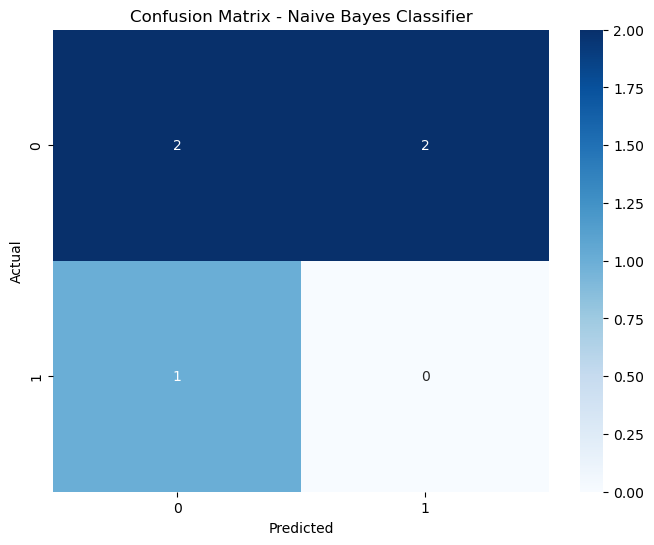

In [284]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


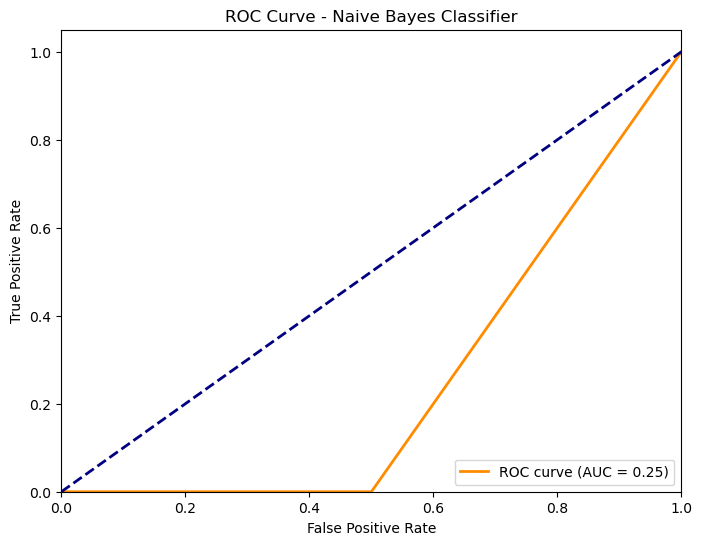

In [285]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes Classifier')
plt.legend(loc='lower right')
plt.show()


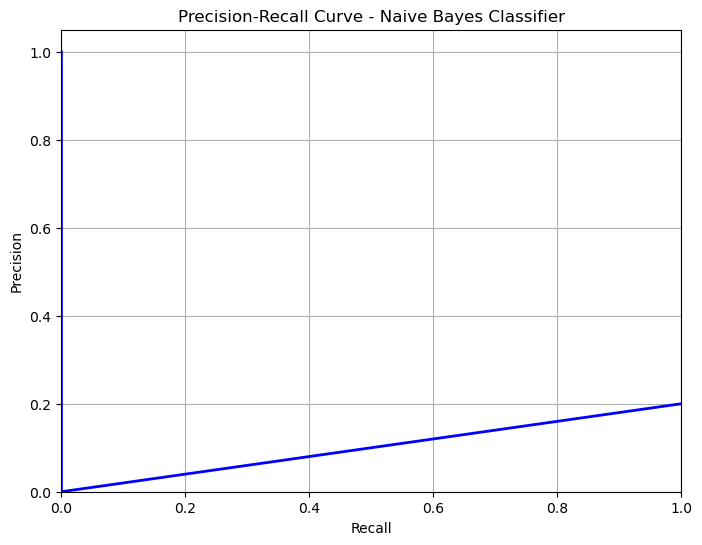

In [286]:
# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


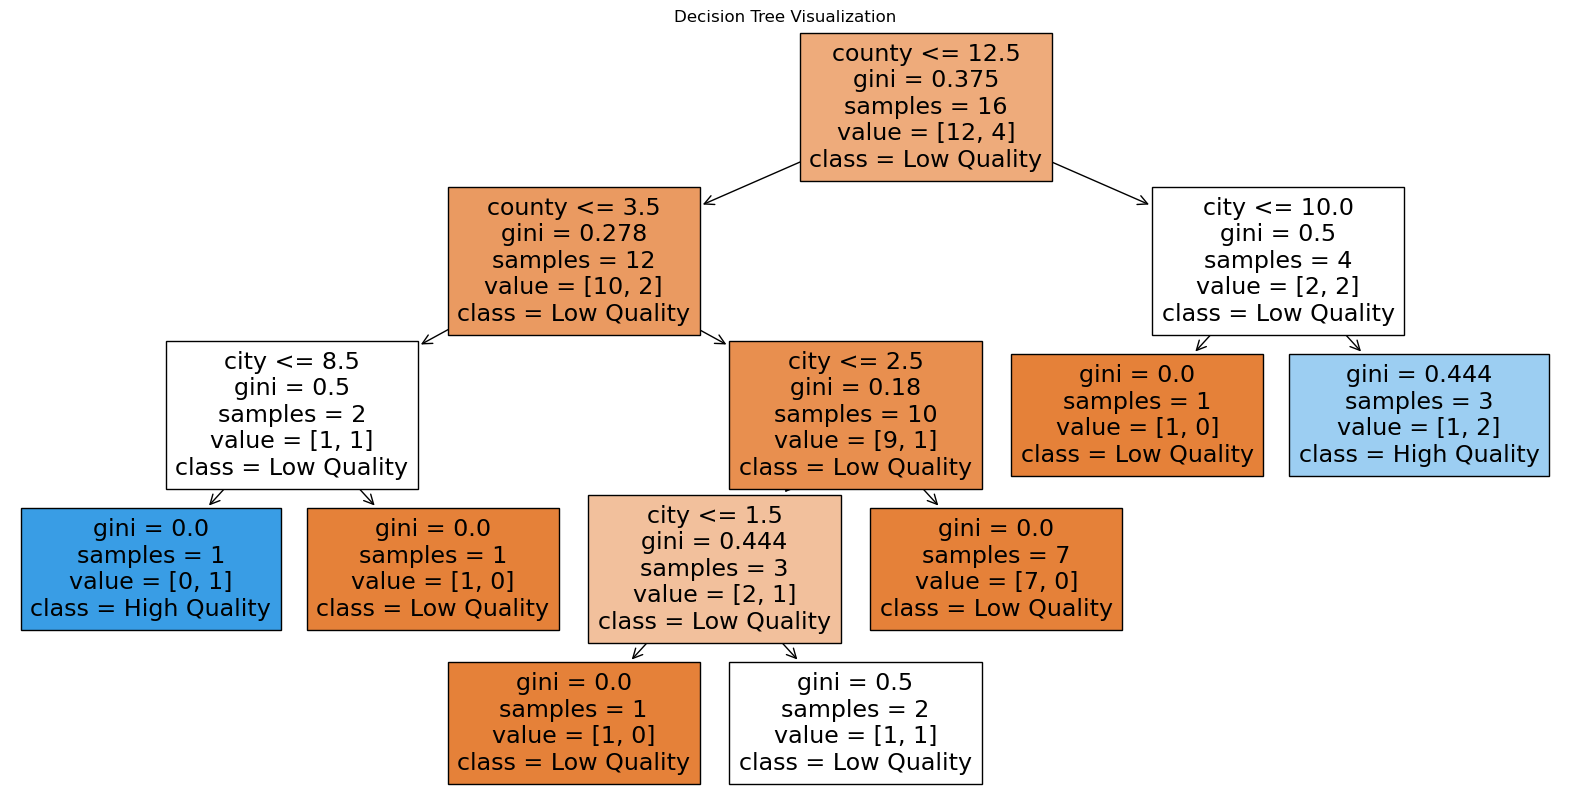

In [287]:
feature_names = list(X.columns)

plt.figure(figsize=(20, 10))
plot_tree(decision_tree_classifier, filled=True, feature_names=feature_names, class_names=['Low Quality', 'High Quality'])
plt.title('Decision Tree Visualization')
plt.show()


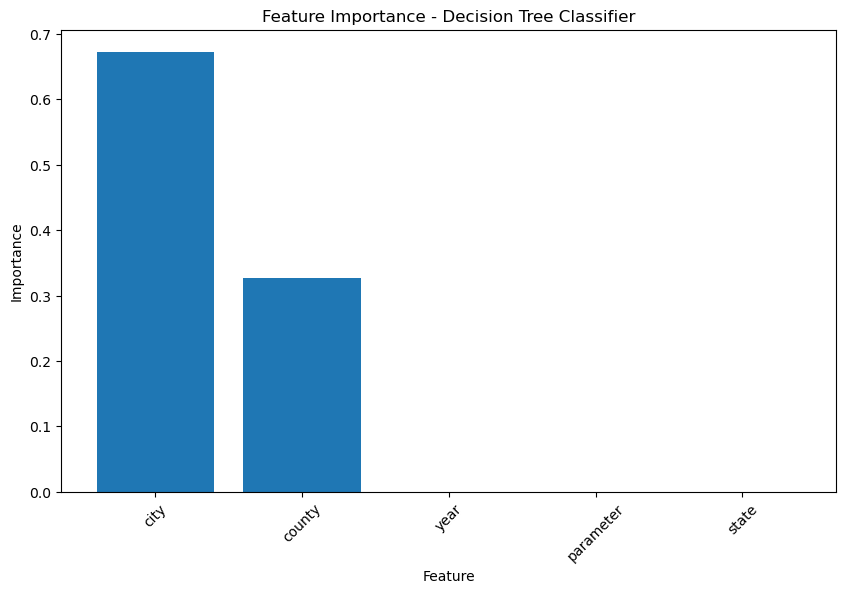

In [288]:
importances = decision_tree_classifier.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.title('Feature Importance - Decision Tree Classifier')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()


In [289]:
fig = px.scatter_3d(d, x='latitude', y='longitude', z='arithmetic_mean', color='kmeans_cluster')
fig.update_layout(title='3-D Visualization of Naive Bayes Classifier')
fig.show()

# Decision Tree Classifier 3-D Visualization
fig = px.scatter_3d(d, x='latitude', y='longitude', z='arithmetic_mean', color='dbscan_cluster')
fig.update_layout(title='3-D Visualization of Decision Tree Classifier')
fig.show()


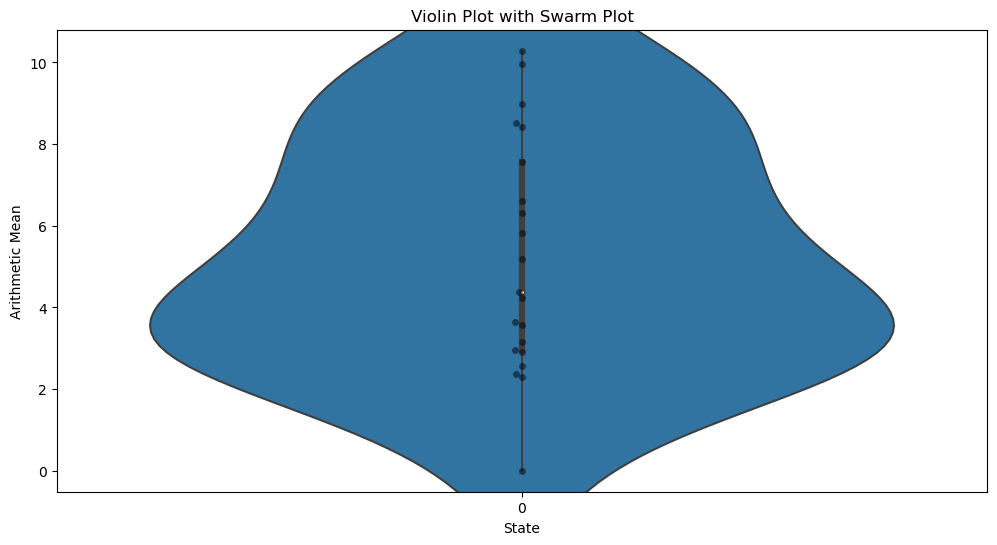

In [290]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='state', y='arithmetic_mean', data=dfc)
sns.swarmplot(x='state', y='arithmetic_mean', data=dfc, color='k', alpha=0.5)
plt.title('Violin Plot with Swarm Plot')
plt.xlabel('State')
plt.ylabel('Arithmetic Mean')
plt.show()


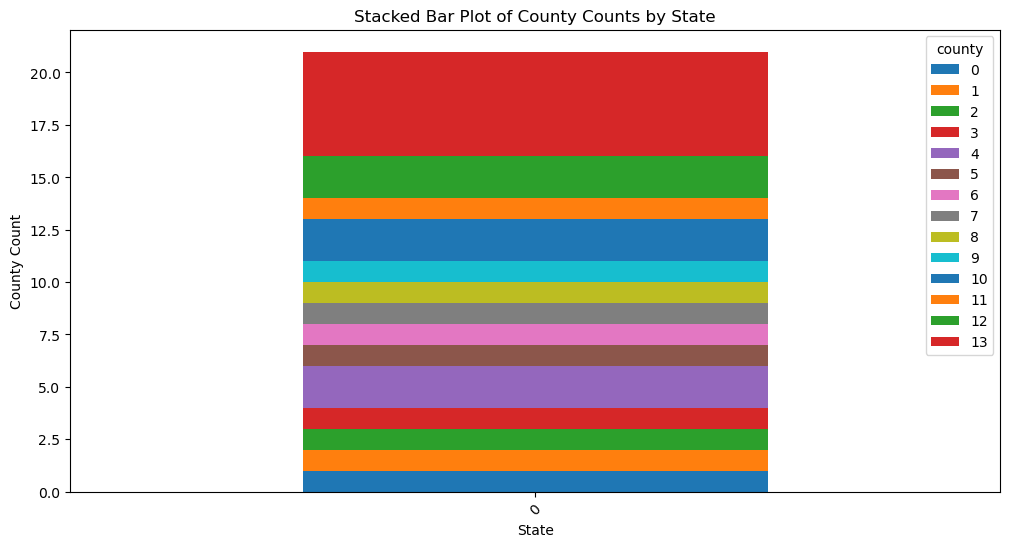

In [291]:
state_county_counts = dfc.groupby(['state', 'county']).size().unstack()
state_county_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Plot of County Counts by State')
plt.xlabel('State')
plt.ylabel('County Count')
plt.xticks(rotation=45)
plt.show()


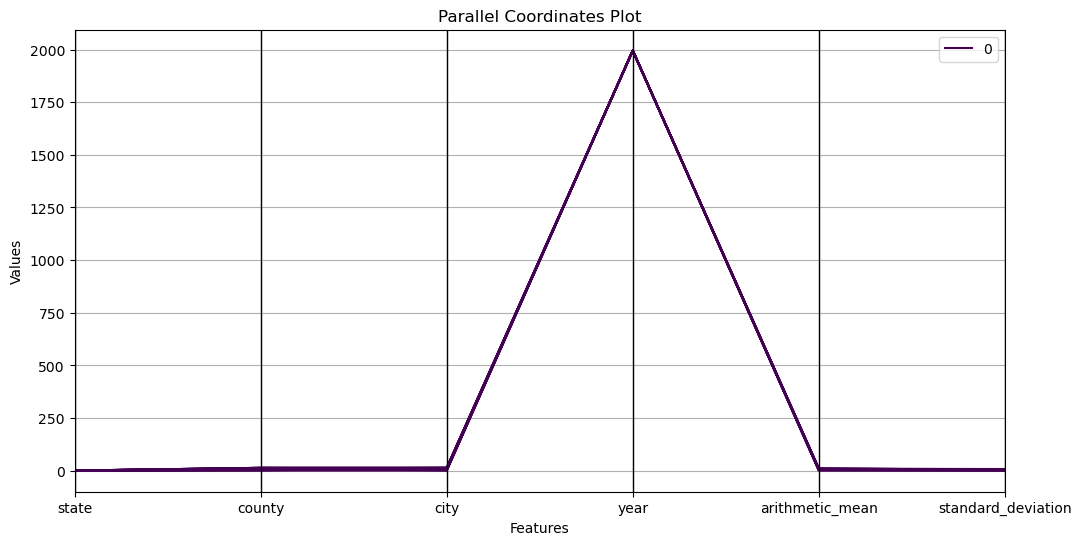

In [292]:
plt.figure(figsize=(12, 6))
parallel_coordinates(dfc[['state', 'county', 'city', 'parameter', 'year', 'arithmetic_mean', 'standard_deviation']], 'parameter', colormap='viridis')
plt.title('Parallel Coordinates Plot')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()


In [293]:
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=dfc.loc[0, ['arithmetic_mean', 'standard_deviation', 'observation_count', 'latitude', 'longitude']],
      theta=['Arithmetic Mean', 'Standard Deviation', 'Observation Count', 'Latitude', 'Longitude'],
      fill='toself',
      name='Site 1'
))

fig.add_trace(go.Scatterpolar(
      r=dfc.loc[1, ['arithmetic_mean', 'standard_deviation', 'observation_count', 'latitude', 'longitude']],
      theta=['Arithmetic Mean', 'Standard Deviation', 'Observation Count', 'Latitude', 'Longitude'],
      fill='toself',
      name='Site 2'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 200]
    )),
  showlegend=True
)

fig.show()
